In [1]:
import pandas as pd
import numpy as np

If you wish to use any alternative sets, simply change the filepaths in this cell

In [285]:
FILEPATHS = {
    "chembl_10k" : "../data/created/chembl_34_10K_RAND.sdf",
    "safe" : "../data/created/non_reactive_compounds_smiles.csv",
    "sus" : "../data/created/suspisious_compounds_smiles.csv",
    "highly_sus" : "../data/created/highly_supisious_compounds_smiles.csv",
    "filters" : "../data/created/substruct_filters_basic_pooling.csv" 
}

To store all data in one place, I like to use a nested dictionary

In [382]:
from collections import defaultdict
sets = defaultdict(lambda: defaultdict(dict))

In [383]:
from rdkit import Chem

sets["sus"]["smiles"] = pd.read_csv(FILEPATHS["sus"])["Isomeric SMILES"]
sets["sus"]["mols"] = [Chem.MolFromSmiles(mol) for mol in sets["sus"]["smiles"]]
sets["safe"]["smiles"] = pd.read_csv(FILEPATHS["safe"])["Isomeric SMILES"]
sets["safe"]["mols"] = [Chem.MolFromSmiles(mol) for mol in sets["safe"]["smiles"]]
sets["high_sus"]["smiles"] = pd.read_csv(FILEPATHS["highly_sus"])["Isomeric SMILES"]
sets["high_sus"]["mols"] = [Chem.MolFromSmiles(mol) for mol in sets["high_sus"]["smiles"]]

[20:10:51] WARNING: not removing hydrogen atom without neighbors


In [5]:
sdf_supplier = Chem.SDMolSupplier(FILEPATHS["chembl_10k"])

In [6]:
sets["chembl"]["mols"] = [mol for mol in sdf_supplier]

[12:13:50] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 10 ignored
[12:13:50] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 27 ignored
[12:13:51] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 154 ignored
[12:13:51] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 6 ignored
[12:13:51] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 63 ignored
[12:13:51] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 19 ignored
[12:13:51] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 108 ignored
[12:13:51] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 16 ignored
[12:13:51] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 13 ignored
[12:13:51] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[12:13:51] Warning: ambiguous stereochemistry - zero final chiral

In [7]:
sets["chembl"]["smiles"] = [Chem.MolToSmiles(mol) for mol in sets["chembl"]["mols"]]

Let's just have a quick look at the sets

In [8]:
from random import sample
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

def display_mol_sample(mol_set, sample_size=10):
    """
    Displays a visual sample of molecules from a given set.
    
    Parameters:
    - mol_set (set): A set of SMILES strings representing molecules.
    - sample_size (int): The number of molecules to sample and display.
    """
    # Sample molecules from the set
    sampled_mols = sample(list(mol_set), min(sample_size, len(mol_set)))

    # Create a subplot grid for displaying the molecules
    n_cols = 5
    n_rows = (sample_size + n_cols - 1) // n_cols  # Calculate rows needed
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
    axs = axs.flatten() if n_rows > 1 else [axs]

    # Plot each molecule
    for ax, mol in zip(axs, sampled_mols):
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    # Hide any unused subplots
    for ax in axs[sample_size:]:
        ax.axis('off')

    plt.show()

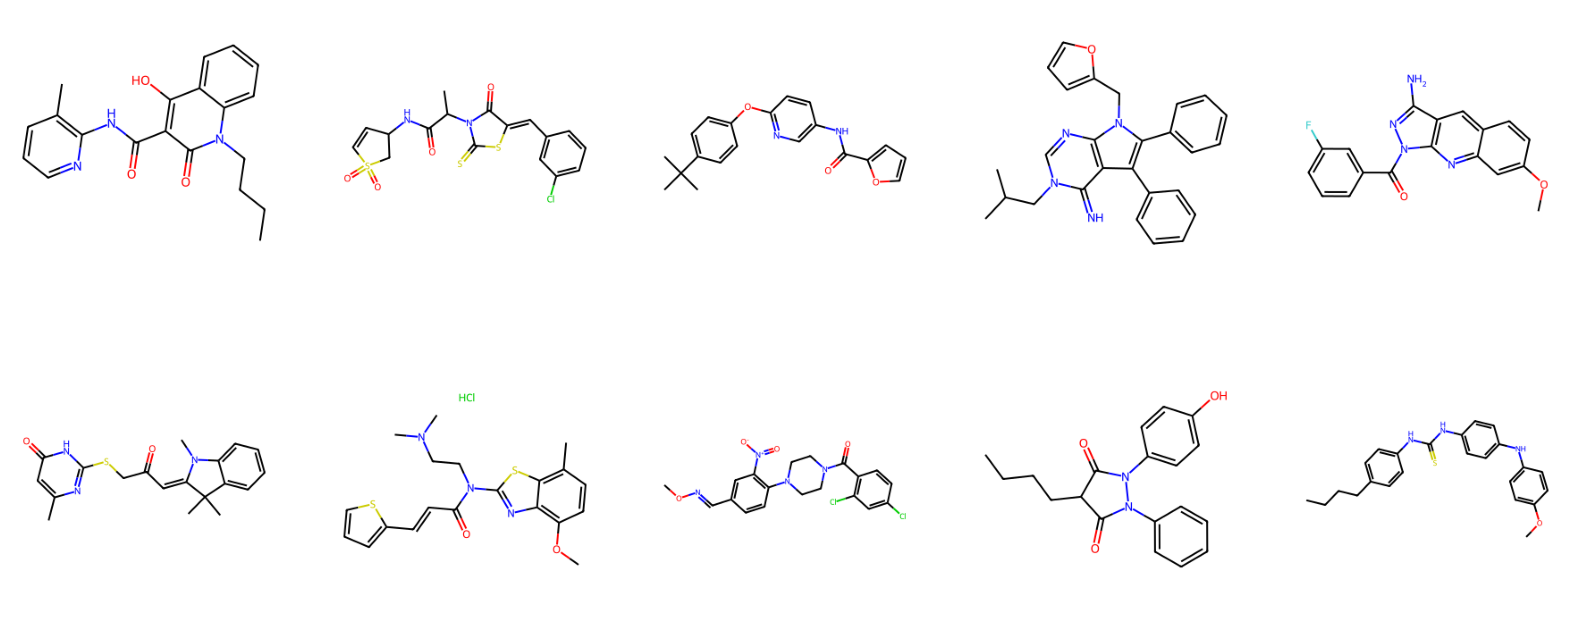

In [9]:
display_mol_sample(sets["sus"]["mols"], sample_size=10)

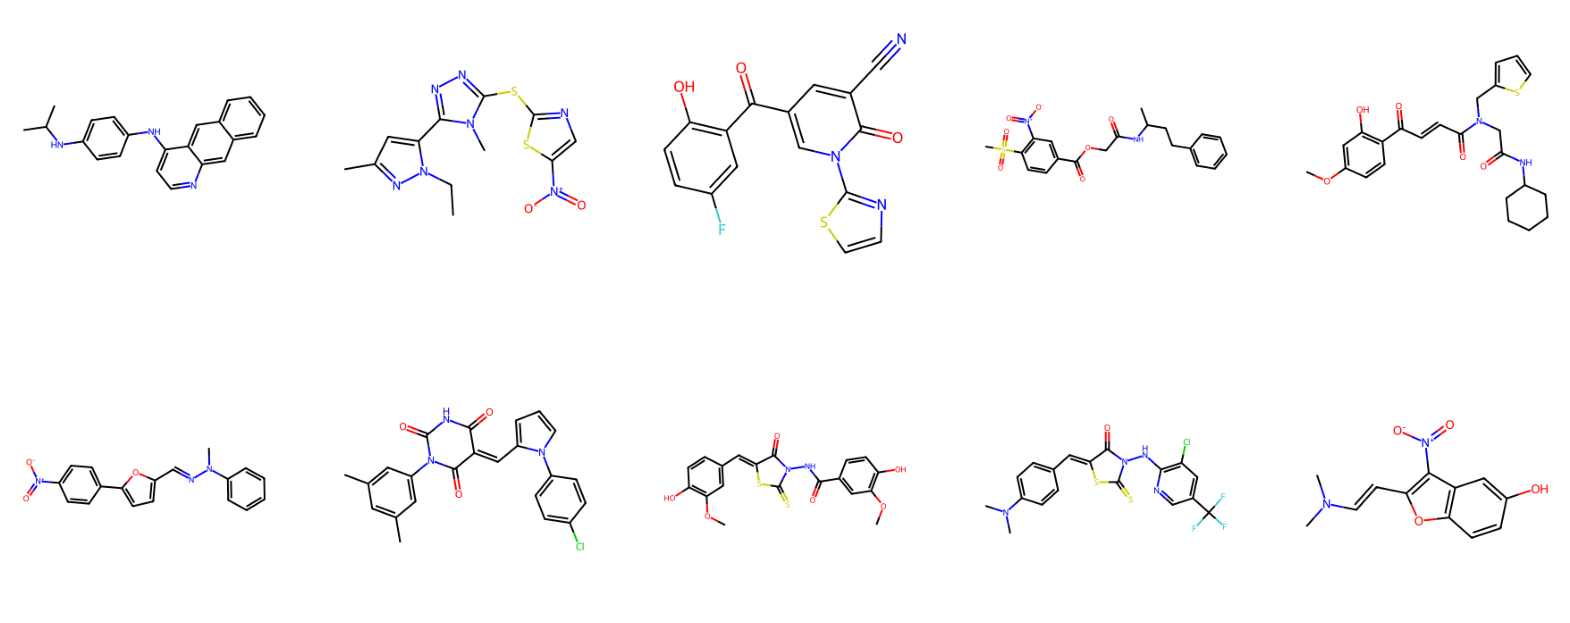

In [10]:
display_mol_sample(sets["high_sus"]["mols"], sample_size=10)

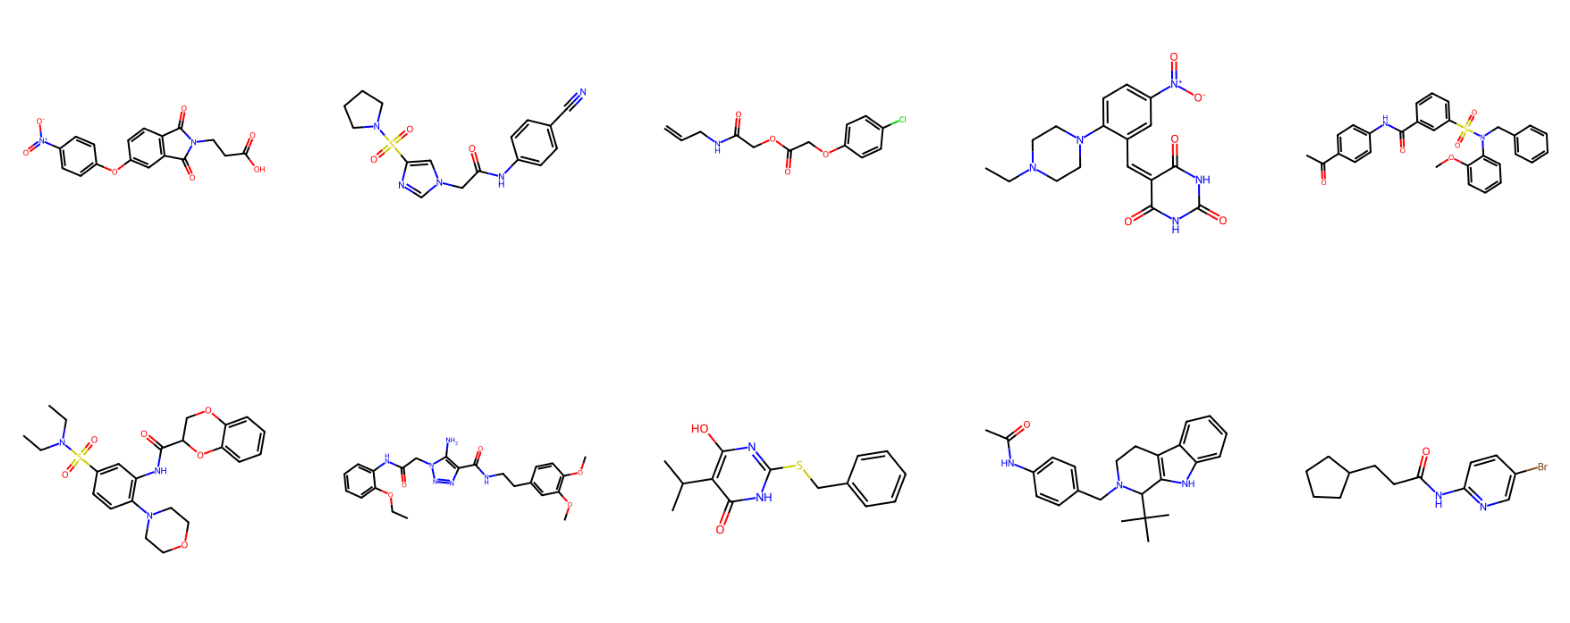

In [288]:
display_mol_sample(sets["safe"]["mols"], sample_size=10)

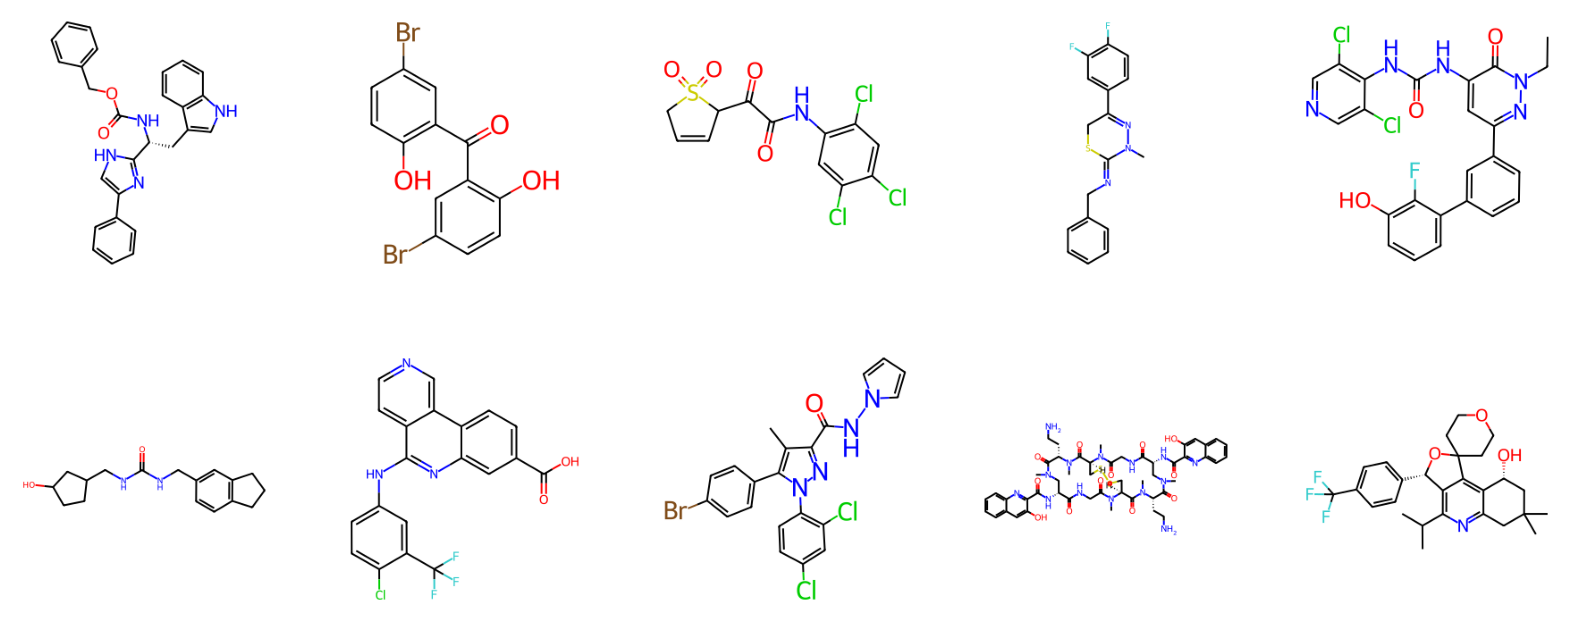

In [11]:
display_mol_sample(sets["chembl"]["mols"], sample_size=10)

### Substructure filters analysis

Since our sets contain structures that are active on a large amount of different assays in pubchem, it would be reasonable to expect that substructure filters dedicated to matching problematic compounds in assays would match them with greater frequency. Let's check for that.

There is however a catch - these compounds may have already been filtered using some of these substructure filters, which we may also notice in the statistics of smarts matching. We'll just keep it in mind while doing the analysis and apply the knowledge while interpreting the results.

I prepared a set of smarts substructure filters from the [medchem repo](https://github.com/datamol-io/medchem/blob/main/medchem/data/common_alerts_collection.csv) by merging filters with identical smarts together. (this procedure can be seen in notebook/promiscuity_filters_matching.ipynb)

In [12]:
filters = pd.read_csv(FILEPATHS['filters'])

In [13]:
filters.head()

standard_smarts            description  \
0           *!@c1c(!@*)c(!@*)c(!@*)c(!@*)c1  {'poly_sub_atomatic'}   
1                                 *(C#N)C#N  {'filter70_alkylcn2'}   
2             *(c1ccccc1)(c1ccccc1)c1ccccc1    {'filter92_trityl'}   
3  *-C(=O)-&!@[N&H1]-C-&!@C(=O)-&!@[N&H1]-*          {'dipeptide'}   
4         *-[#7]1-c2ccccc2-[#16]-c2ccccc2-1      {'phenothiazine'}   

      rule_set_name           source  
0    {'surechembl'}       {'chembl'}  
1  {'inpharmatica'}       {'chembl'}  
2  {'inpharmatica'}       {'chembl'}  
3         {'mlsmr'}       {'chembl'}  
4     {'ld50-oral'}  {'litterature'}

In [289]:
matches_per_set = {key : 0 for key in sets.keys()}

In [290]:
matches_per_rule_set = defaultdict(lambda : defaultdict(dict))
unique_values = {item for rule_set in filters["rule_set_name"] for item in eval(rule_set)}

In [291]:
matches_per_rule_set = {
    rule_set : {
        key : {
            "total" : 0,
            "matched" : 0
        } for key in sets.keys()
    } for rule_set in unique_values
}

In [292]:
matches_per_rule = {
    rule_id : {
        key : 0 for key in sets.keys()
    } for rule_id in range(len(filters))
}

In [293]:
smarts_mols = [Chem.MolFromSmarts(smarts) for smarts in filters["standard_smarts"]]

for i in tqdm(range(len(filters))):
    smarts_mol = smarts_mols[i]

    for set_name, set_data in sets.items():
        for mol in set_data["mols"]:
            match_found = mol.HasSubstructMatch(smarts_mol)
            if match_found:
                matches_per_rule[i][set_name] += 1
                matches_per_set[set_name] += 1

            for rule_set_name in eval(filters.iloc[i]["rule_set_name"]):
                if match_found:
                    matches_per_rule_set[rule_set_name][set_name]["matched"] += 1
                matches_per_rule_set[rule_set_name][set_name]["total"] += 1

100%|██████████| 2229/2229 [53:13<00:00,  1.43s/it]


In [294]:
match_rates = matches_per_set.copy()

In [295]:
for key in match_rates.keys():
    match_rates[key] = matches_per_set[key] / len(sets[key]['mols'])

<Axes: >

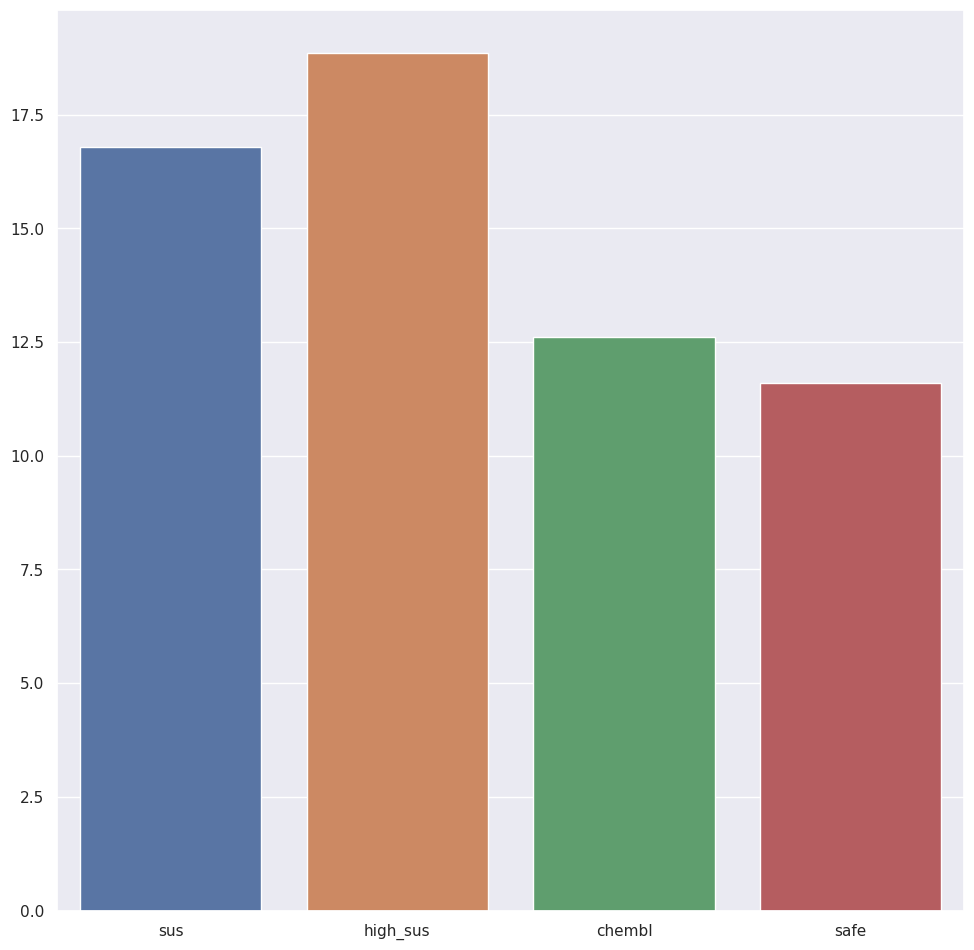

In [297]:
import seaborn as sns
sns.barplot(x=list(match_rates.keys()), y=list(match_rates.values()))

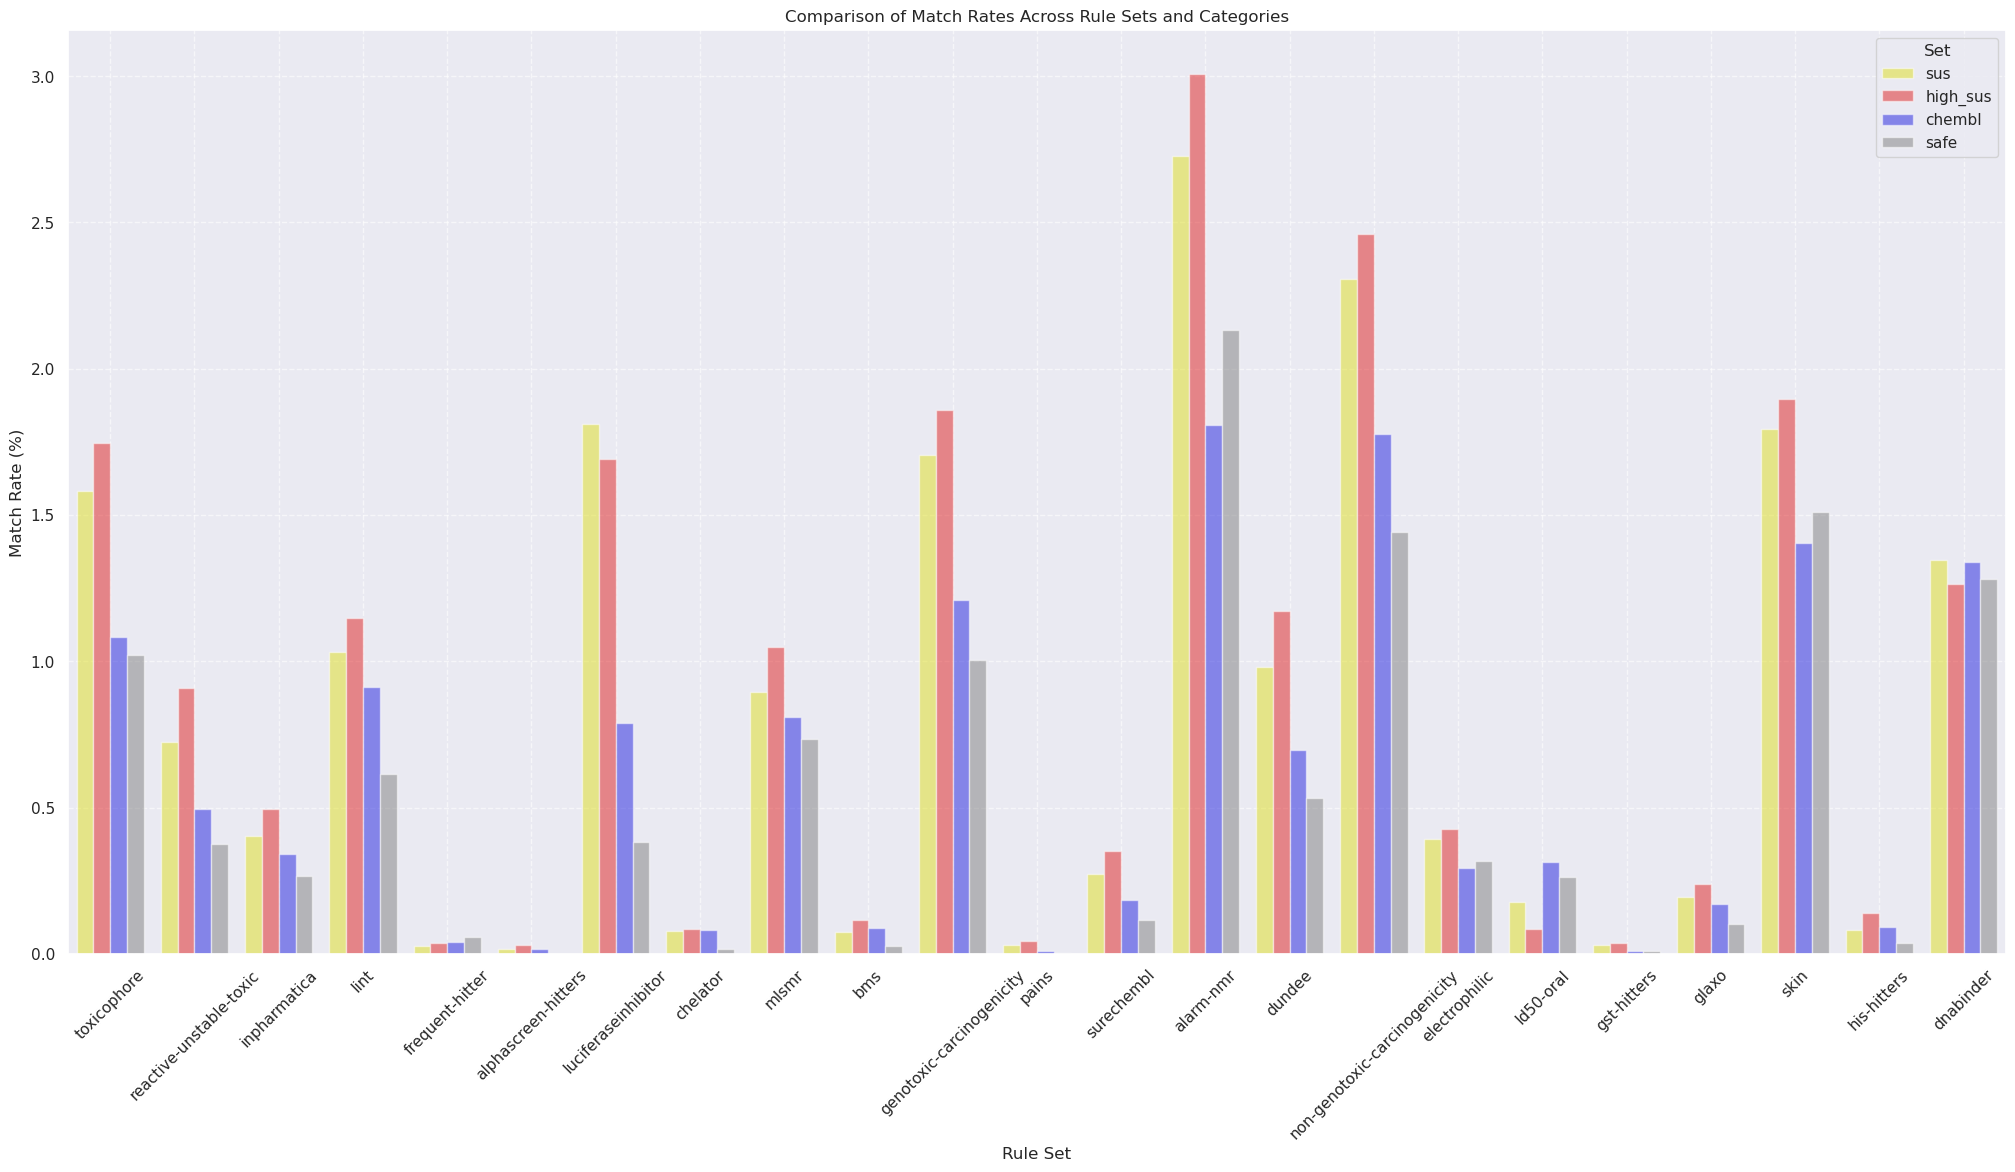

In [302]:
rows = []

for rule_set, matches in matches_per_rule_set.items():
    for set_name, values in matches.items():
        match_rate = (values['matched'] / values['total']) * 100
        rows.append({
            'Rule Set': rule_set,
            'Set': set_name,
            'Match Rate (%)': match_rate
        })

# Create DataFrame
df = pd.DataFrame(rows)

# Plot using seaborn
plt.figure(figsize=(25, 12))
sns.barplot(data=df, x='Rule Set', y='Match Rate (%)', hue='Set', palette={'sus': 'yellow', 
                                                                           'high_sus': 'red', 'chembl': 'blue', "safe" : "gray"}, alpha=0.5)
plt.title('Comparison of Match Rates Across Rule Sets and Categories')
plt.ylabel('Match Rate (%)')
plt.xlabel('Rule Set')
plt.xticks(rotation=45)
plt.legend(title='Set')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [303]:
matches_per_rule_pctg = matches_per_rule.copy()

In [587]:
for key in matches_per_rule_pctg.keys():
    for set_name in sets.keys():
        matches_per_rule_pctg[key][set] = matches_per_rule[key][set] / len(sets[set]["mols"])

In [305]:
enrichment = [0] * len(matches_per_rule)
high_enrichment = [0] * len(matches_per_rule)

In [306]:
for i in range(len(matches_per_rule)):
    if matches_per_rule_pctg[i]["safe"] == 0:
        if matches_per_rule_pctg[i]["sus"] == 0:
            enrichment[i] = 0
            high_enrichment[i] = 0
        else:
            if matches_per_rule_pctg[i]["high_sus"] == 0:
                high_enrichment[i] = 0
            else:
                high_enrichment[i] = np.inf
            enrichment[i] = np.inf
    else:
        enrichment[i] = matches_per_rule_pctg[i]["sus"] / matches_per_rule_pctg[i]["safe"]
        high_enrichment[i] = matches_per_rule_pctg[i]["high_sus"] / matches_per_rule_pctg[i]["safe"]

In [307]:
filters["enrichment"] = enrichment
filters["high_enrichment"] = high_enrichment

In [308]:
top_20_smarts = filters[filters["enrichment"] != np.inf].sort_values(by="enrichment", ascending=False).head(20)["standard_smarts"].to_list()

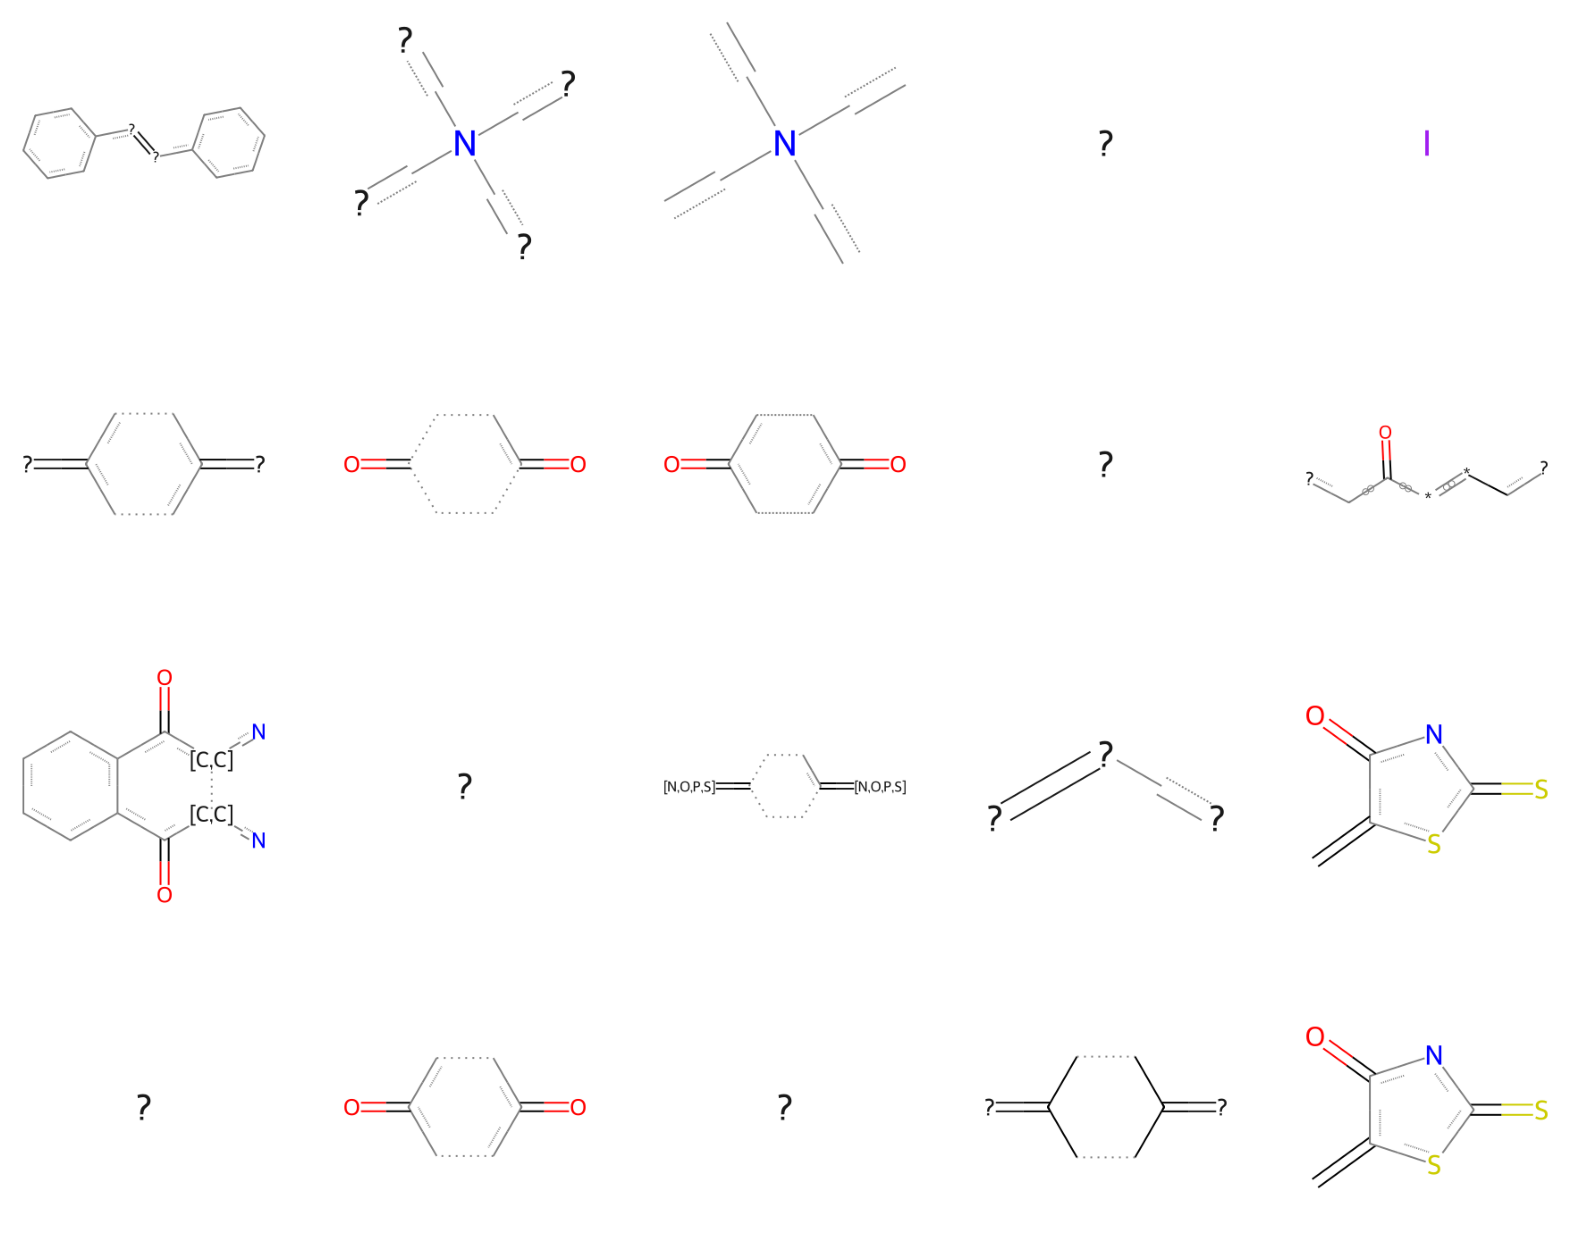

In [309]:
display_mol_sample([Chem.MolFromSmarts(smarts) for smarts in top_20_smarts], sample_size=20)

Comparison via descriptors

In [310]:
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors

In [311]:
descriptors = {
    keys : {
        descriptor_name : [] for descriptor_name in ["rings", "rotatable", "atomcount", "hba", "hbd", "molwt", "tpsa", "logp"]
    } for keys in sets.keys()
}

In [312]:
from rdkit.Chem import AllChem 
for set_name in tqdm(sets.keys()):
    descriptors[set_name]["rings"] = [len(AllChem.GetSSSR(m)) for m in sets[set_name]["mols"]]
    descriptors[set_name]["rotatable"] = [AllChem.CalcNumRotatableBonds(m) for m in sets[set_name]["mols"]]
    descriptors[set_name]["atomcount"] = [m.GetNumHeavyAtoms() for m in sets[set_name]["mols"]]
    descriptors[set_name]["hba"] = [rdescriptors.CalcNumLipinskiHBA(m) for m in sets[set_name]["mols"]]
    descriptors[set_name]["hbd"] = [rdescriptors.CalcNumLipinskiHBD(m) for m in sets[set_name]["mols"]]
    descriptors[set_name]["molwt"] = [rdescriptors.CalcExactMolWt(m) for m in sets[set_name]["mols"]]
    descriptors[set_name]["tpsa"] = [rdescriptors.CalcTPSA(m) for m in sets[set_name]["mols"]]
    descriptors[set_name]["logp"] = [Descriptors.MolLogP(m) for m in sets[set_name]["mols"]]

100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


In [338]:
data = []
for set_name in descriptors.keys():
    # For each molecule, collect all descriptor values and the set name
    for i in range(len(descriptors[set_name]["rings"])):  # Assuming all lists are the same length
        entry = {
            "set": set_name,
            "rings": descriptors[set_name]["rings"][i],
            "rotatable": descriptors[set_name]["rotatable"][i],
            "atomcount": descriptors[set_name]["atomcount"][i],
            "hba": descriptors[set_name]["hba"][i],
            "hbd": descriptors[set_name]["hbd"][i],
            "molwt": descriptors[set_name]["molwt"][i],
            "tpsa": descriptors[set_name]["tpsa"][i],
            "logp": descriptors[set_name]["logp"][i],
        }
        data.append(entry)

# Create a DataFrame
descriptors_df = pd.DataFrame(data)

In [345]:
descriptors_df.groupby("set").median()

rings  rotatable  atomcount  hba  hbd       molwt    tpsa     logp
set                                                                         
chembl      3.0        5.0       28.0  6.0  1.0  394.110148  76.700  3.37760
high_sus    3.0        4.0       26.0  6.0  1.0  372.601438  73.755  3.57672
safe        3.0        5.0       25.0  6.0  1.0  355.135448  75.020  2.75892
sus         3.0        4.0       26.0  6.0  1.0  369.168856  72.190  3.65138

In [340]:
sns.set(rc={'figure.figsize':(11.7, 11.7)})

In [341]:
melted_df = pd.melt(descriptors_df, id_vars=['set'], value_vars=['rings', 'rotatable', 'atomcount', 'hba', 'hbd', 'logp'])

<Axes: xlabel='variable', ylabel='value'>

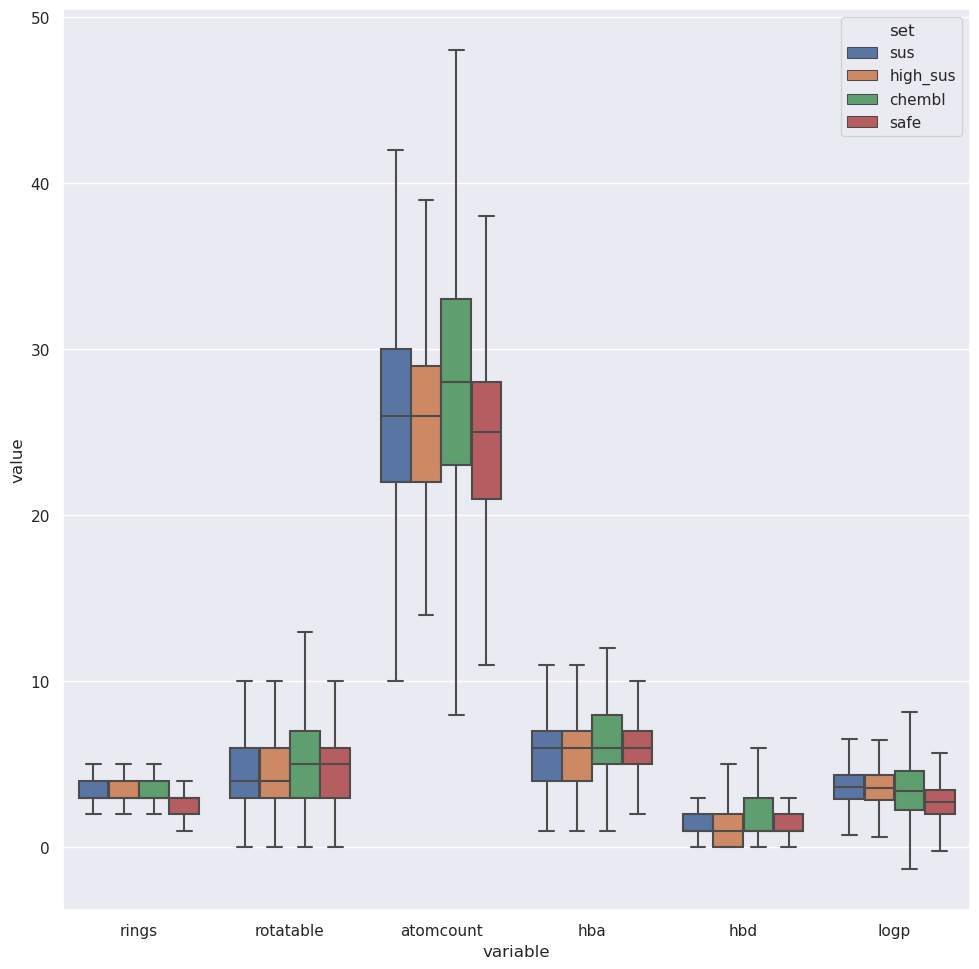

In [342]:
sns.boxplot(y='value', x='variable', hue='set', data=melted_df, showfliers=False)

<Axes: xlabel='variable', ylabel='value'>

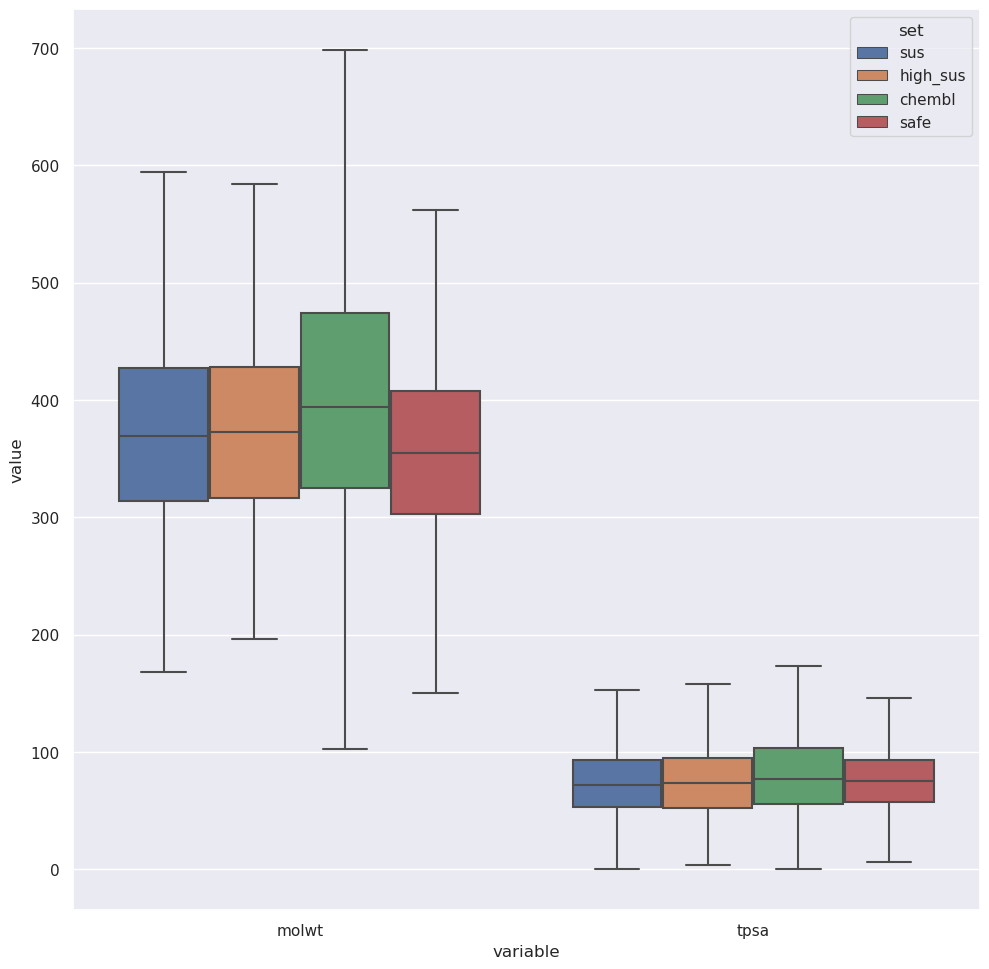

In [346]:
melted_df2 = pd.melt(descriptors_df, id_vars=['set'], value_vars=['molwt', 'tpsa'])
sns.boxplot(y='value', x='variable', hue='set', data=melted_df2, showfliers=False)

scaffolds

In [347]:
from rdkit.Chem.Scaffolds import MurckoScaffold
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

In [348]:
for set_name in sets.keys():
    sets[set_name]["scaffolds"] = [scaffold(mol) for mol in tqdm(sets[set_name]["mols"], f"Processing: {set_name}")]

Processing: safe: 100%|██████████| 10000/10000 [00:02<00:00, 3714.32it/s]


In [349]:
for set_name in sets.keys():
    sets[set_name]["scaffold_smiles"] = [Chem.MolToSmiles(mol) for mol in tqdm(sets[set_name]["scaffolds"], f"Processing: {set_name}") if mol]

Processing: safe: 100%|██████████| 10000/10000 [00:00<00:00, 18682.72it/s]


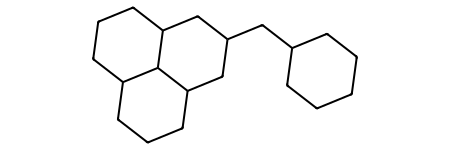

In [350]:
sets["sus"]["scaffolds"][4]

In [351]:
scaffold_counts = {
    set_name : {} for set_name in sets.keys()
}

In [352]:
for set_name in sets.keys():
    for scaffold_smiles in sets[set_name]["scaffold_smiles"]:
        scaffold_counts[set_name][scaffold_smiles] = scaffold_counts[set_name].get(scaffold_smiles, 0) + 1 

In [353]:
scaffold_pctgs = scaffold_counts.copy()
for set_name in scaffold_pctgs.keys():
    for scaffold_smiles in scaffold_pctgs[set_name].keys():
        scaffold_pctgs[set_name][scaffold_smiles] = scaffold_pctgs[set_name][scaffold_smiles] / len(sets[set_name]["mols"])

In [354]:
enrichment = {}
for scaffold_smiles in scaffold_pctgs["sus"].keys():
    chembl_result = scaffold_pctgs["safe"].get(scaffold_smiles, 0)
    if chembl_result == 0:
         enrichment[scaffold_smiles] = np.inf
    else:
        enrichment[scaffold_smiles] = scaffold_pctgs["sus"][scaffold_smiles] / chembl_result  

In [355]:
scaffold_enrichment_df = pd.DataFrame(data = {
    "scaffold_smiles" : enrichment.keys(),
    "enrichment" : enrichment.values()
}
)

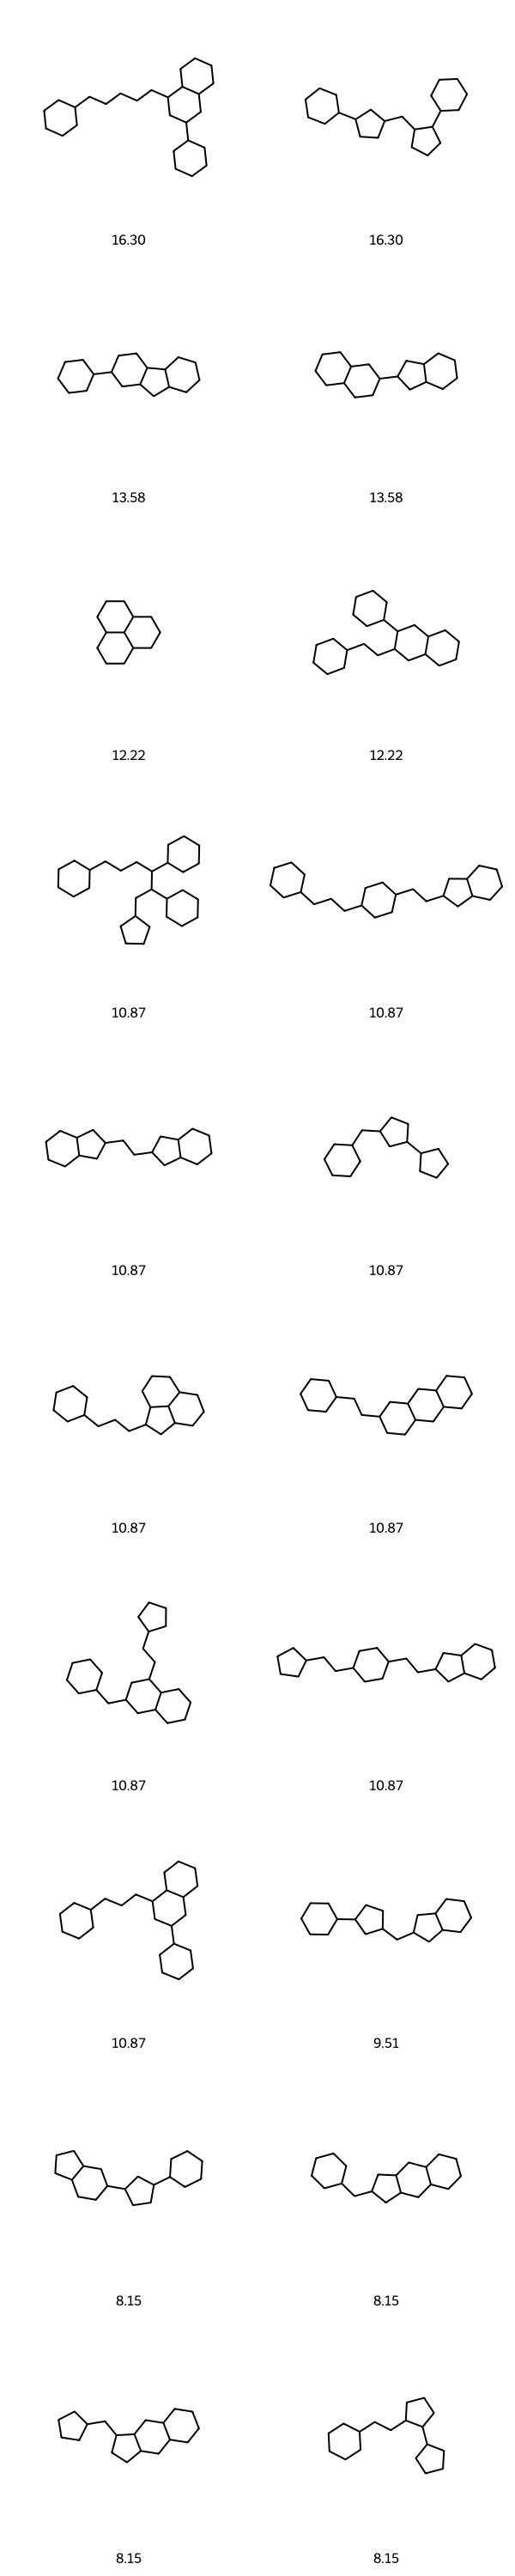

In [356]:
top_20 = scaffold_enrichment_df.loc[scaffold_enrichment_df["enrichment"] != np.inf].sort_values(by="enrichment", ascending=False).head(20)

mols = [Chem.MolFromSmiles(scaffold) for scaffold in top_20['scaffold_smiles']]
enrichments = [f"{enrich:.2f}" for enrich in top_20['enrichment']]

Draw.MolsToGridImage(mols,
                           molsPerRow=2,
                           subImgSize=(300, 300),
                           legends=enrichments)

### Visualizations

In [541]:
for set_name in sets.keys():
    morgan_fps = []
    bit_infos = []

    for mol in sets[set_name]["mols"]:
        bit_info = {}  # Dictionary to store bit information
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1048, bitInfo=bit_info)
        
        morgan_fps.append(fp)
        bit_infos.append(bit_info)
        
    sets[set_name]["morgan_fp"] = morgan_fps
    sets[set_name]["bit_info"] = bit_infos

In [542]:
sets["sus"]["bit_info"][0]

{10: ((7, 1), (10, 1)),
 34: ((7, 0), (10, 0)),
 74: ((0, 1),),
 86: ((11, 2),),
 137: ((0, 0), (13, 0), (14, 0)),
 171: ((11, 1),),
 308: ((2, 1),),
 318: ((5, 2),),
 341: ((12, 2),),
 353: ((13, 1), (14, 1)),
 439: ((3, 0), (8, 0), (3, 2)),
 445: ((6, 2),),
 455: ((8, 2),),
 458: ((4, 1),),
 480: ((9, 1),),
 511: ((6, 1),),
 632: ((9, 2),),
 654: ((1, 2),),
 694: ((4, 2),),
 706: ((2, 0), (5, 0), (12, 0)),
 721: ((3, 1),),
 751: ((5, 1), (12, 1)),
 788: ((8, 1),),
 796: ((1, 0), (4, 0), (6, 0), (9, 0), (11, 0)),
 830: ((1, 1),),
 1016: ((2, 2),)}

In [359]:
def bitvect_to_list(bitvect):
    return [int(bitvect.GetBit(i)) for i in range(bitvect.GetNumBits())]

set_names = []
morgan_fps = []

for set_name in sets.keys():
    set_names += [set_name] * len(sets[set_name]["mols"])
    morgan_fps += [bitvect_to_list(fp) for fp in sets[set_name]["morgan_fp"]]

df = pd.DataFrame(data={
    "set_name" : set_names,
    "morgan_fp" : morgan_fps
})

In [360]:
from sklearn.decomposition import PCA

X = pd.DataFrame(df['morgan_fp'].tolist())

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['set_name'] = df['set_name']  # Add the set names for coloring

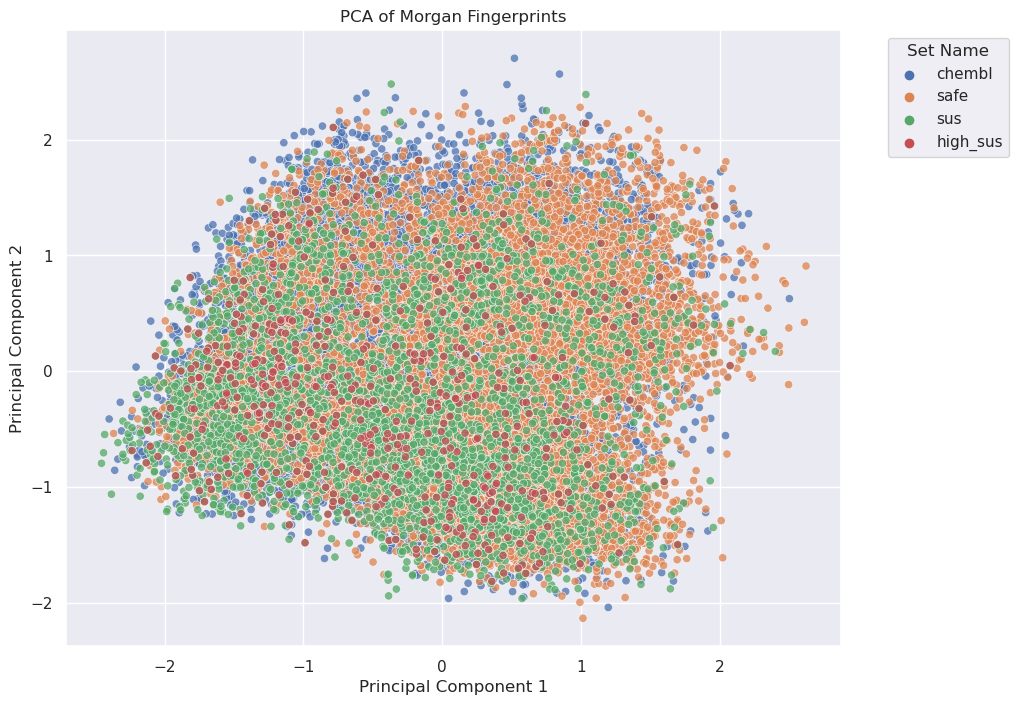

In [361]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='set_name', 
                data=pca_df.sort_values(by="set_name", key=lambda x: x.map({"chembl" : 0, "safe" : 1, "sus" : 2, "high_sus" : 3})), 
                palette="deep",
                alpha=0.75)
plt.title('PCA of Morgan Fingerprints')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Set Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### MDS

This cell is time intensive

In [362]:
from scipy.spatial import distance

sparse_mat = distance.pdist(list(df["morgan_fp"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [363]:
from sklearn import manifold
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

/opt/conda/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [364]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

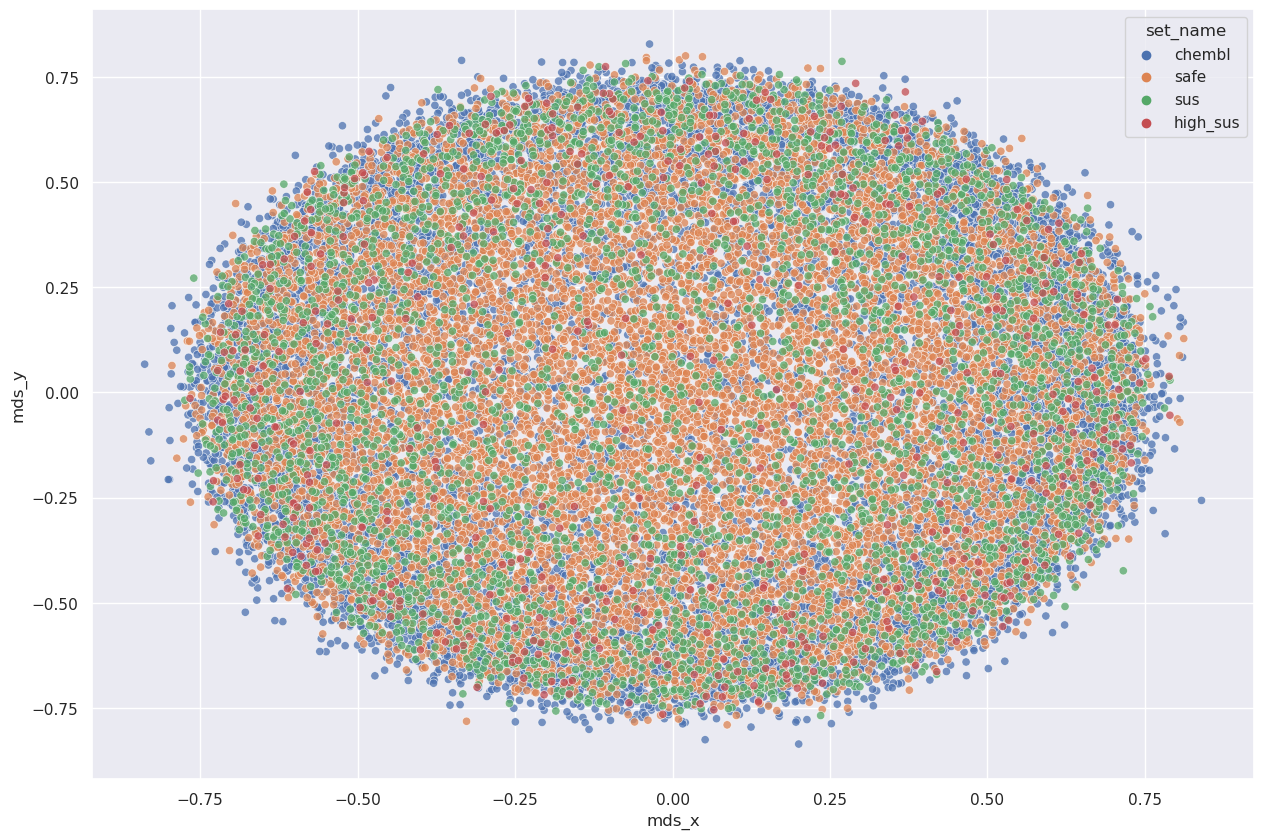

In [370]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values(by="set_name", key=lambda x: x.map({"chembl" : 0, "safe" : 1, "sus" : 2, "high_sus" : 3})),
                      hue="set_name",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [371]:
from sklearn import manifold

In [372]:
clf = manifold.TSNE(n_components=2, metric="precomputed", init="random")
X_tsne = clf.fit_transform(dist_mat)

In [373]:
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

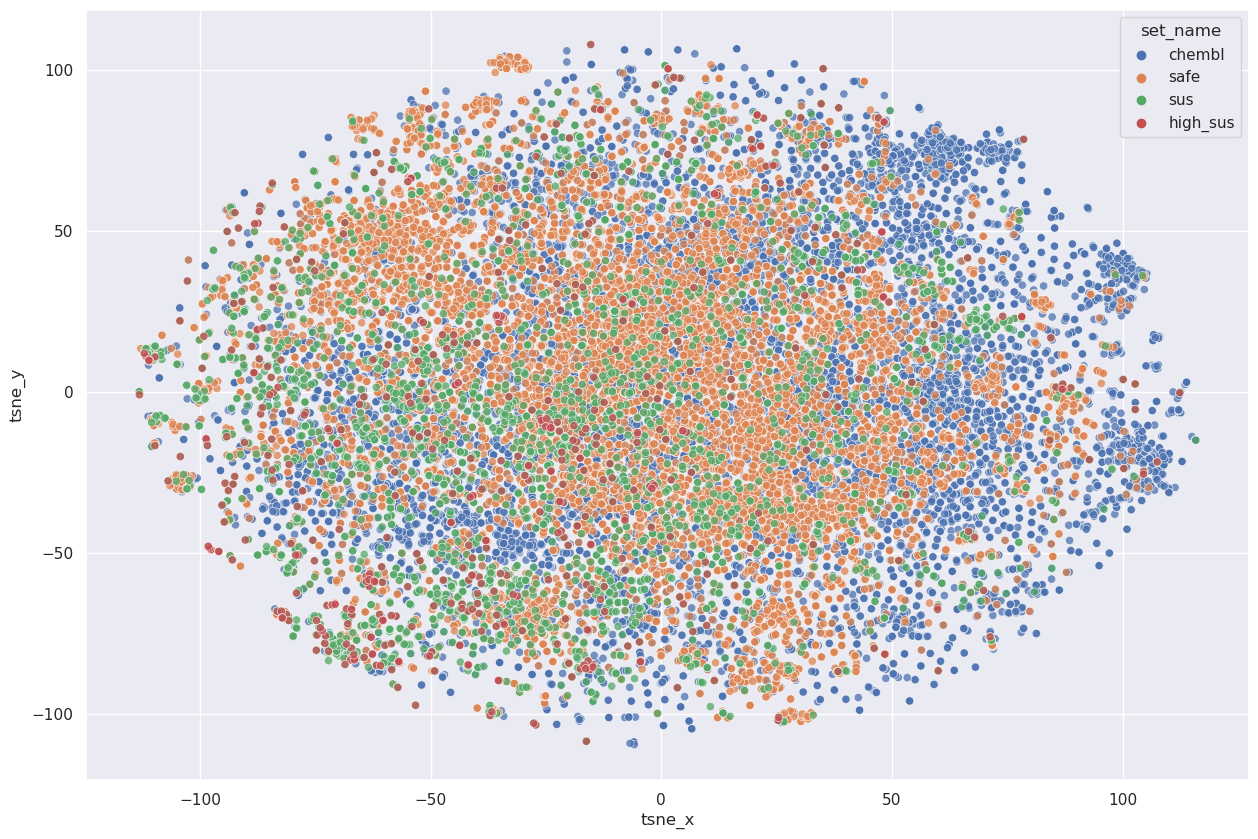

In [375]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values(by="set_name", key=lambda x: x.map({"chembl" : 0, "safe" : 1, "sus" : 2, "high_sus" : 3})),
                      hue="set_name",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### Classification

We'll work with the safe and sus sets, trying to find ways to classify a compound as suspisious.

What I was personally most curious about was if it was possible to use the vectors of smarts matching for predictions.

Let's first create these vectors for all the compounds from the sus and safe datasets.

In [422]:
mols = []
set_names = []

for set_name in ["sus", "safe"]:
    if set_name == "sus":
        set_names += [1] * len(sets[set_name]["mols"])
    else:
        set_names += [0] * len(sets[set_name]["mols"])
    mols += sets[set_name]["mols"]

In [389]:
def get_smarts_match_vector(mol, smarts_patterns_mols):
    results = np.zeros(len(smarts_patterns_mols), dtype=int)
    for i, smarts in enumerate(smarts_patterns_mols):
        results[i] = mol.HasSubstructMatch(smarts)
    return results

In [402]:
from scipy.sparse import lil_matrix, csr_matrix, csc_matrix, save_npz, load_npz

In [ ]:
sparse_matrix = lil_matrix((len(class_data), len(smarts_mols)), dtype=np.int8)
sparse_matrix

In [394]:
for idx, mol in enumerate(tqdm(mols)):
    sparse_matrix[idx, :] = get_smarts_match_vector(mol, smarts_mols)

100%|██████████| 13681/13681 [02:40<00:00, 85.13it/s] 


In [395]:
sparse_matrix

<13681x2229 sparse matrix of type '<class 'numpy.int8'>'
	with 177758 stored elements in List of Lists format>

In [410]:
column_sums = np.abs(sparse_matrix).sum(axis=0)
column_sums

matrix([[ 23,  20,   9, ...,   0, 380, 327]])

In [413]:
empty_columns = np.where(column_sums == 0)[1]
empty_columns

array([   5,   10,   15, ..., 2222, 2223, 2226])

In [414]:
non_empty_columns = np.delete(np.arange(sparse_matrix.shape[1]), empty_columns)
non_empty_columns

array([   0,    1,    2, ..., 2225, 2227, 2228])

In [415]:
filtered_matrix = sparse_matrix[:, non_empty_columns]

In [416]:
smarts_match_csr = csr_matrix(filtered_matrix)
smarts_match_csr

<13681x1082 sparse matrix of type '<class 'numpy.int8'>'
	with 177758 stored elements in Compressed Sparse Row format>

In [424]:
len(set_names)

13681

In [425]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [426]:
X_train, X_test, y_train, y_test = train_test_split(smarts_match_csr, set_names, test_size=0.2, random_state=42)

In [436]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500]  
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')


grid_search.fit(smarts_match_csr, set_names)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'n_estimators': 400}
Best cross-validation score: 0.81


In [437]:
# Make predictions
clf = RandomForestClassifier(random_state=42, n_estimators=400)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8268176835951772
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      1987
           1       0.75      0.55      0.63       750

    accuracy                           0.83      2737
   macro avg       0.80      0.74      0.76      2737
weighted avg       0.82      0.83      0.82      2737



In [439]:
importances = clf.feature_importances_

In [446]:
importance_df = pd.DataFrame(data = {"filter_id" : non_empty_columns, "importance" : importances})

In [474]:
filter_importance_df = pd.merge(importance_df, filters.reset_index(names="filter_id")[["filter_id", "standard_smarts", "enrichment"]], on="filter_id", how="left")

In [497]:
top_important_filters = filter_importance_df.sort_values(by="importance", ascending=False)[["standard_smarts", "importance", "enrichment"]].head(40)

In [498]:
top_important_filters

standard_smarts  importance  \
208                       Oc1[a&R1][a&R1]a[a&R1][a&R1]1    0.027986   
1037  c1ccccc1[$([Br,Cl,F,I])&!$([Br,Cl,F,I]aa[Br,Cl...    0.023540   
771                                       [N&X3](C)(C)C    0.020279   
547   [$(n),$([#7&H1]),$([#7&H0&!$([N&X3]=O)])]c1ccccc1    0.018732   
899   [c&H1,$(c(c)(c)[C&X4])]1[c&H1][c&H1][c&H1,$(c(...    0.016783   
839                                   [O&X2&H1]c1ccccc1    0.014183   
1045                                            c1ccco1    0.014168   
253   [!$(C=C)&!$(C#C)]C(=[O,S&X1,N])[O,S,N][C&X4,O,...    0.013597   
721   [N&!$([N&+])&!$(NC=[O,N])]c1[a&R1][a&R1]a[a&R1...    0.012453   
910   [c,C;!$(C=O);!$(C=N);!$(C=S)][S&!$(S=O)][c,C;!...    0.011506   
1003             c1c([O,N&H2,N&H1])c([O,N&H2,N&H1])ccc1    0.011140   
299                                    [#6]-C(=O)O-[#6]    0.010725   
1064                                                csc    0.010655   
887   [a&!r0][$([N&H2]),$([N&X3&H1][#6]),$([N&X3]([#...    0.010133   
789   [N,C,S,O]-&!@[N,C,S,O]-&!@[N,C,S,O]-&!@[N,C,S,...    0.010042   
1047                                            c1ccnc1    0.009972   
584   [C&H1,$([C&!R](=[O,S&X1])[#6&!R])](=[O,S&X1])[...    0.009971   
1078                                            s1cccc1    0.009817   
222                                          S(=O)(=O)N    0.009672   
524   [$(c1([N&X3]([#1,#6])[#1,#6])ccccc1),$(c1([O&H...    0.009328   
254             [!$(C=C)&!$(C#C)]C(=[O,S&X1,N])[O,S,N]a    0.008906   
853                        [R0&D2][R0&D2][R0&D2][R0&D2]    0.008852   
918                       [c,n]1[c,n][c,n][c,n][c,n]n1C    0.008718   
17                              *[N,S,O]-&!@[N,S,O][#6]    0.008558   
385                                         [#6]n1cncc1    0.008104   
420                  [$(C=C),$(C#C),a][C&H2,C&H1][O,S]a    0.007876   
900   [c&H1]1[c&H1,$(c(c)(o)C)]o[c&H1,$(c(c)(o)C)][c...    0.007684   
688                [C,N,O,S,a]c1[n,o,s]c2ccccc2[n,o,s]1    0.007669   
542   [$(c[N&H1][#6])&r6&!$(c(aC)(aC)[N&H1][#6])&!$(...    0.007608   
237                                       S[c,C][c,C]=O    0.007513   
952   aC=C[$(N(=[O&X1])=[O&X1]),$(C=O),$(C#N),$(S=O)...    0.007465   
730                             [N&D1&!R]#[C&D2&!R][#6]    0.007392   
298                                     [#6]-C(=O)-[#6]    0.006881   
681                                   [C&X4][F,Cl,Br,I]    0.006697   
450   [$([$([a&R3]),$([$([a&R2]([a&R])([a&R])[a&R])]...    0.006596   
505   [$([a&!r0][N&H1][C&X3]=[O&X1]),$(c1c([N&X2]=[N...    0.006370   
508   [$([a&R3].[n,o,s]),$([$([a&R2]([a&R])([a&R])[a...    0.006321   
890              [a&!r0][$([N&X3&H2]),$([N&X3&H1][#6])]    0.006267   
656             [C&X4,a&!r0][C&X3](=[O&X1])[C&X4,a&!r0]    0.006259   
891      [a&!r0][$([N&X3&H2]),$([N&X3&H1][C&X4,a&!r0])]    0.006209   

      enrichment  
208     1.087971  
1037    1.082385  
771     0.711726  
547     1.204743  
899     0.982825  
839     5.235942  
1045    1.317165  
253     0.454871  
721     1.312296  
910     0.654334  
1003    1.055682  
299     0.672084  
1064    1.295695  
887     1.096924  
789     0.593771  
1047    1.957299  
584     0.605670  
1078    1.241595  
222     0.560674  
524     1.693017  
254     0.845844  
853     0.919554  
918     0.618725  
17      0.637860  
385     0.976527  
420     1.322685  
900     0.872860  
688     2.266761  
542     1.011862  
237     0.692236  
952     3.996109  
730     1.424873  
298     1.676311  
681     1.444046  
450     4.047813  
505     0.826676  
508     4.322725  
890     1.098847  
656     1.221074  
891     1.098564

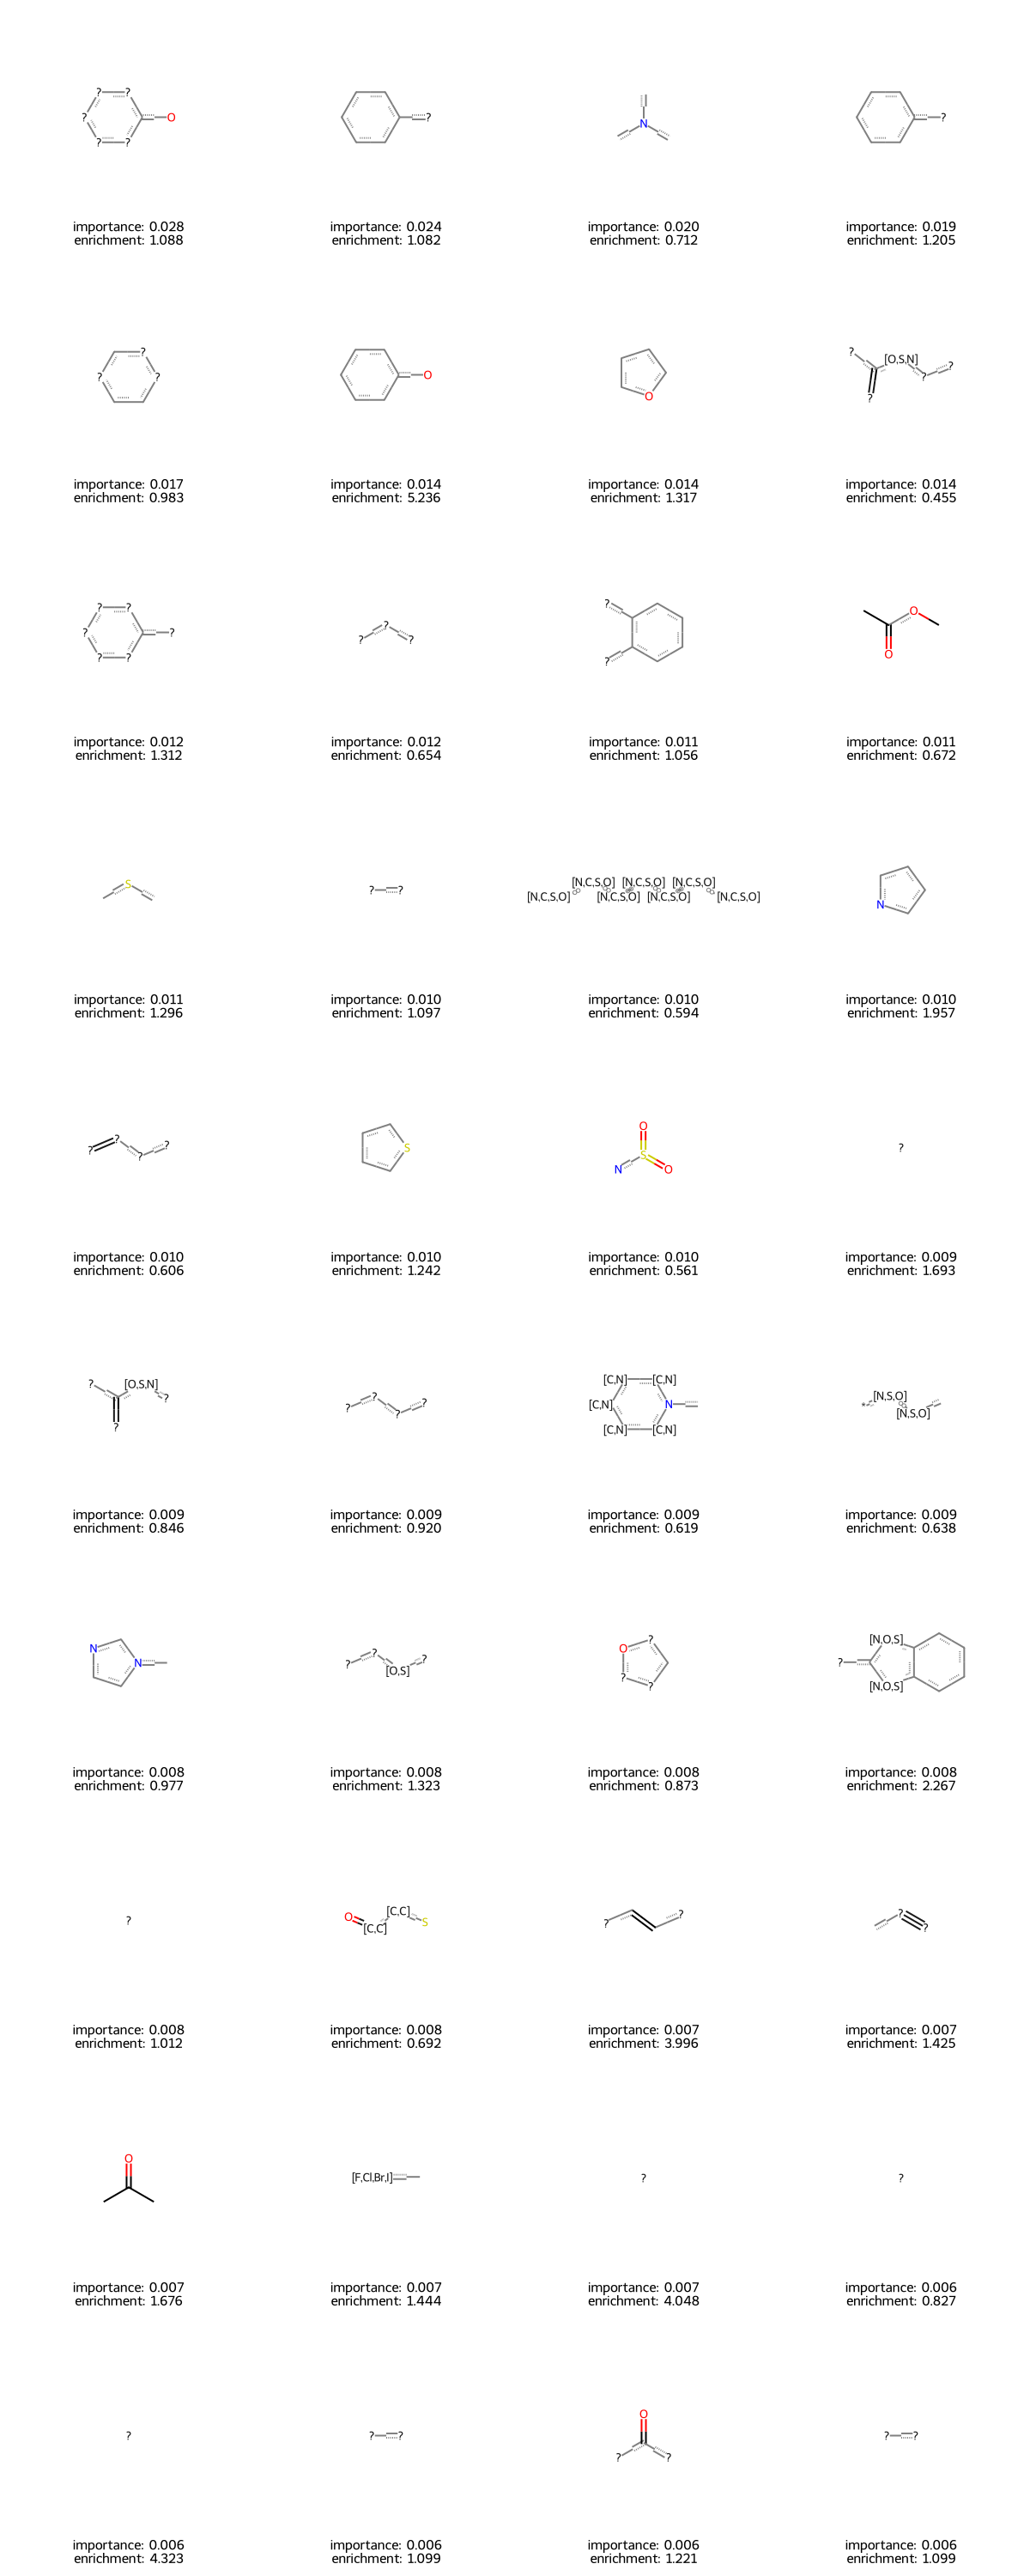

In [499]:
Draw.MolsToGridImage(mols = [Chem.MolFromSmarts(smarts) for smarts in top_important_filters["standard_smarts"].to_list()],
                           molsPerRow=4,
                           subImgSize=(300, 300),
                           legends=[
                               f"importance: {top_important_filters.iloc[i]['importance']:.3f}\n" +
                               f"enrichment: {top_important_filters.iloc[i]['enrichment']:.3f}" for i in range(len(top_important_filters))
                           ])

Let's try to do the same thing with fingerprints

In [506]:
class_df = df.loc[df["set_name"].isin(["sus", "safe"]), ["set_name", "morgan_fp"]]

In [512]:
class_df["set_name"] = np.where(class_df["set_name"] == "sus", 1, 0)

In [516]:
y = class_df["set_name"].values
X = np.stack(class_df["morgan_fp"].values)

In [519]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [526]:
clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')


grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'n_estimators': 500}
Best cross-validation score: 0.83


In [527]:
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [528]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8359517720131531
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1987
           1       0.87      0.47      0.61       750

    accuracy                           0.84      2737
   macro avg       0.85      0.72      0.75      2737
weighted avg       0.84      0.84      0.82      2737



In [529]:
importances = clf.feature_importances_


In [530]:
# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]  # This reverses the array to descending order

# Optionally, display the top N important features
top_n = 20  # You can adjust this value as needed
top_indices = indices[:top_n]
print("Top 20 most important features (fragments):")
for i in top_indices:
    print(f"Feature {i}, Importance: {importances[i]}")


Top 20 most important features (fragments):
Feature 350, Importance: 0.010226100463656632
Feature 256, Importance: 0.00997933671397066
Feature 34, Importance: 0.00727632149727291
Feature 893, Importance: 0.005992593742265662
Feature 479, Importance: 0.005958515230128311
Feature 841, Importance: 0.0059574452823528915
Feature 207, Importance: 0.00553532227556887
Feature 898, Importance: 0.005481333816986709
Feature 939, Importance: 0.005341631685682266
Feature 559, Importance: 0.0053113218326962305
Feature 901, Importance: 0.005242434607500069
Feature 25, Importance: 0.004844982669560346
Feature 13, Importance: 0.004656840417932279
Feature 439, Importance: 0.004593549089960374
Feature 444, Importance: 0.004401334471285604
Feature 791, Importance: 0.004144089347217007
Feature 313, Importance: 0.004071076963863798
Feature 151, Importance: 0.004017438876248518
Feature 171, Importance: 0.0037966682116824376
Feature 961, Importance: 0.0037631687455763683


In [622]:
import random
def get_random_mol_with_bit(set_name, bit_index):
    mols_with_bit = [mol for mol, fp, bit_info in zip(sets[set_name]["mols"], sets[set_name]["morgan_fp"], sets[set_name]["bit_info"]) if fp.GetBit(bit_index) and bit_index in bit_info]

    if mols_with_bit:
        selected_mol = random.choice(mols_with_bit)
        bi = sets[set_name]["bit_info"][sets[set_name]["mols"].index(selected_mol)]

        highlight_atoms = [atom_idx for _, atom_idx in bi[bit_index]]
        env = Chem.FindAtomEnvironmentOfRadiusN(selected_mol, radius=2, rootedAtAtom=highlight_atoms[0])
    
        # Get the atoms involved in the environment
        highlight_atoms = set(highlight_atoms)
        for bond in env:
            highlight_atoms.add(selected_mol.GetBondWithIdx(bond).GetBeginAtomIdx())
            highlight_atoms.add(selected_mol.GetBondWithIdx(bond).GetEndAtomIdx())
        
        img = Draw.MolToImage(selected_mol, highlightAtoms=list(highlight_atoms))
        return img
    return None

350 safe 1


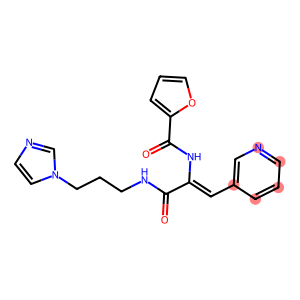

350 safe 2


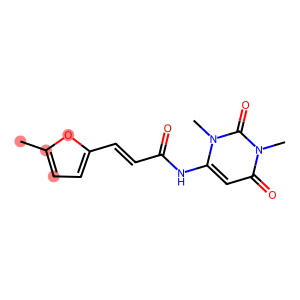

350 sus 1


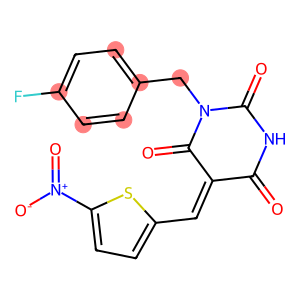

350 sus 2


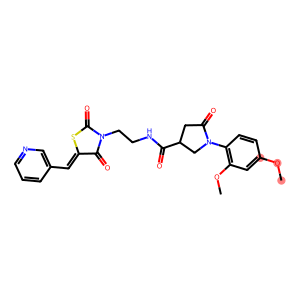

256 safe 1


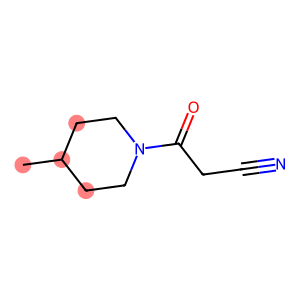

256 safe 2


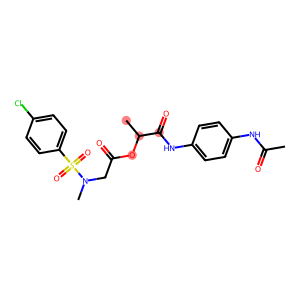

256 sus 1


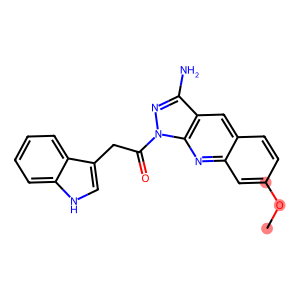

256 sus 2


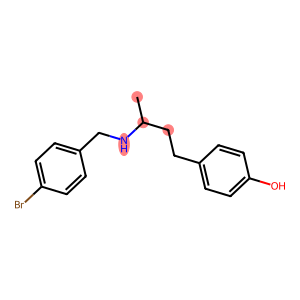

34 safe 1


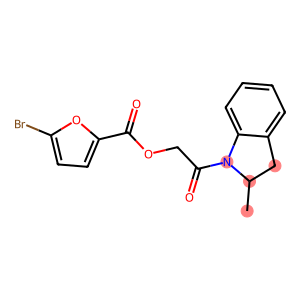

34 safe 2


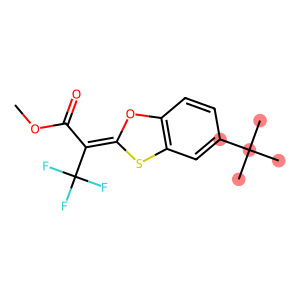

34 sus 1


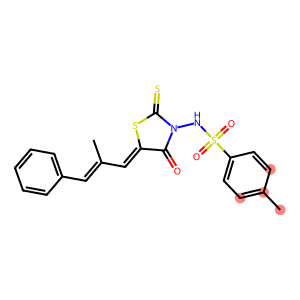

34 sus 2


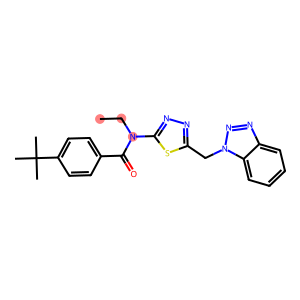

893 safe 1


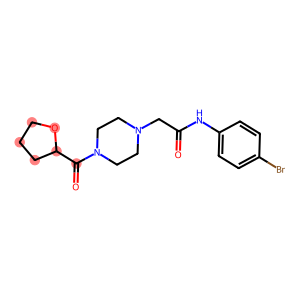

893 safe 2


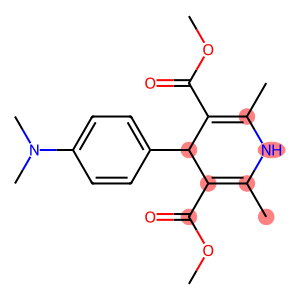

893 sus 1


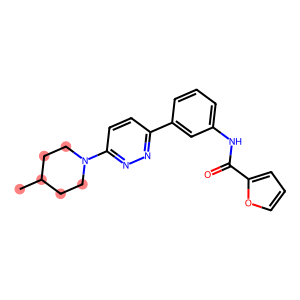

893 sus 2


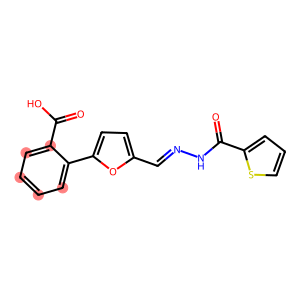

479 safe 1


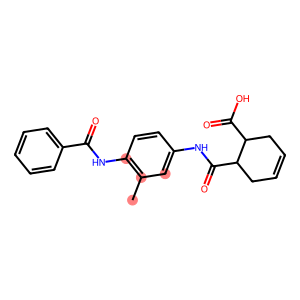

479 safe 2


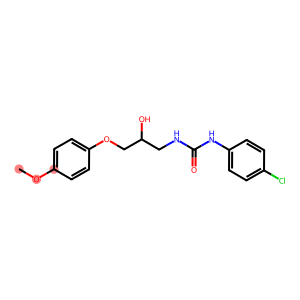

479 sus 1


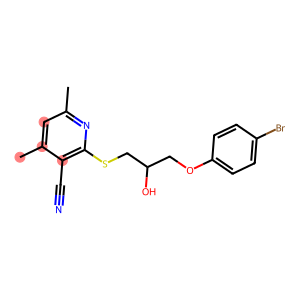

479 sus 2


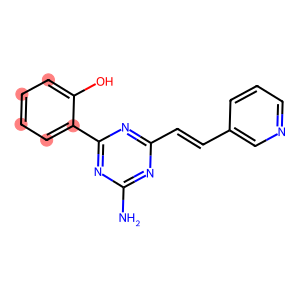

841 safe 1


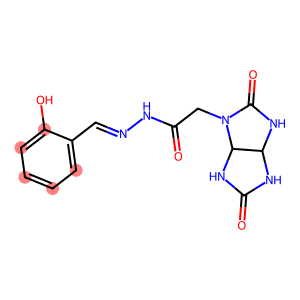

841 safe 2


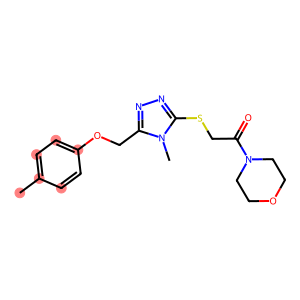

841 sus 1


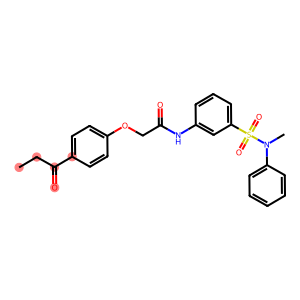

841 sus 2


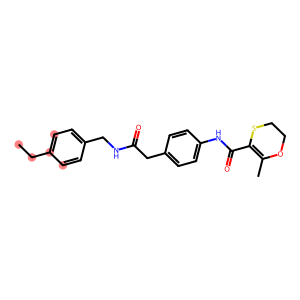

207 safe 1


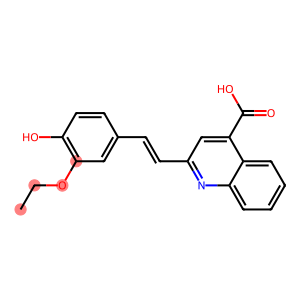

207 safe 2


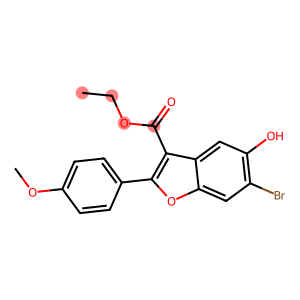

207 sus 1


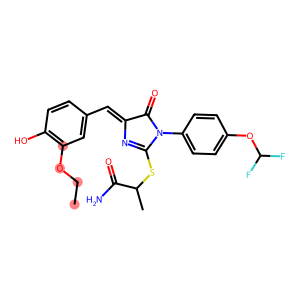

207 sus 2


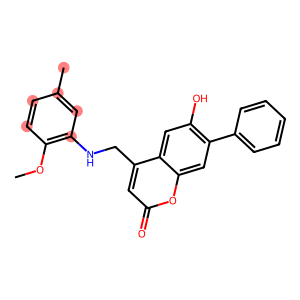

898 safe 1


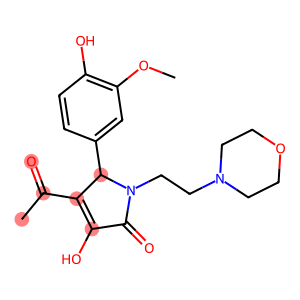

898 safe 2


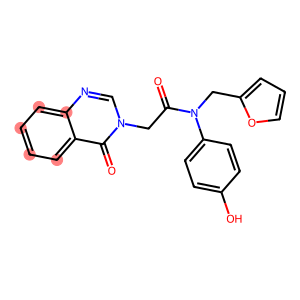

898 sus 1


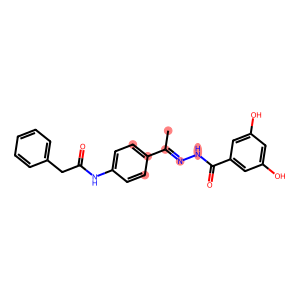

898 sus 2


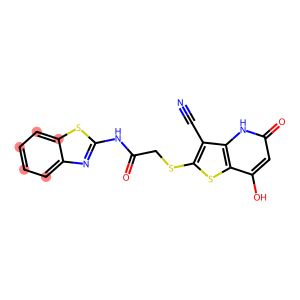

939 safe 1


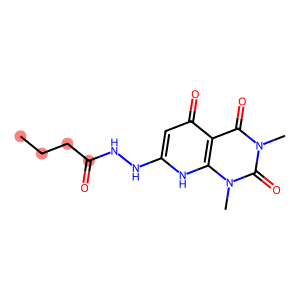

939 safe 2


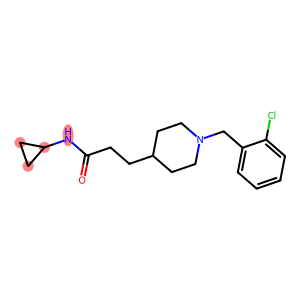

939 sus 1


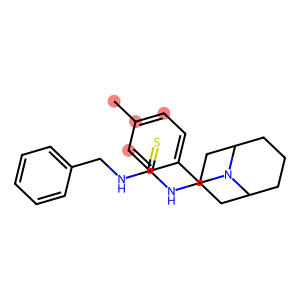

939 sus 2


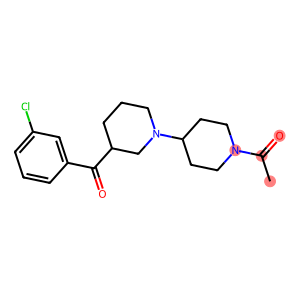

559 safe 1


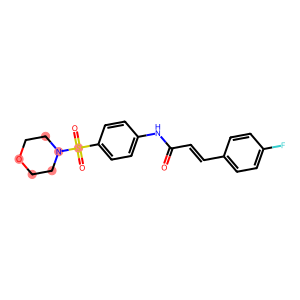

559 safe 2


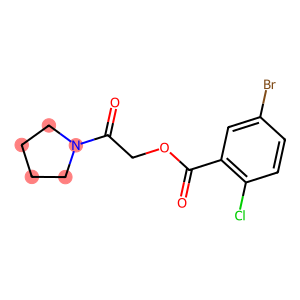

559 sus 1


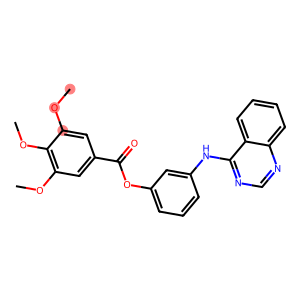

559 sus 2


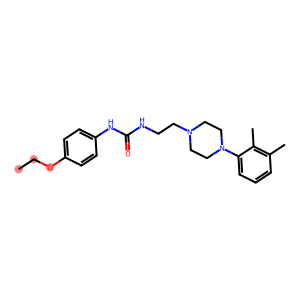

901 safe 1


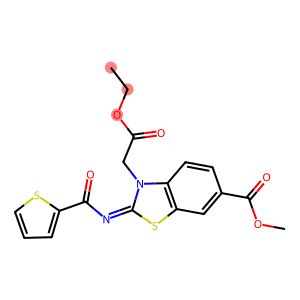

901 safe 2


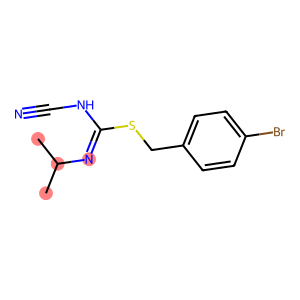

901 sus 1


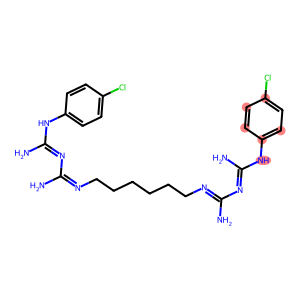

901 sus 2


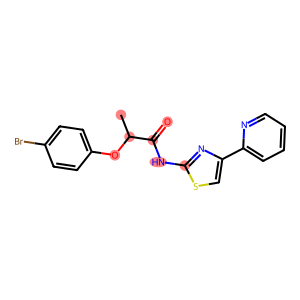

25 safe 1


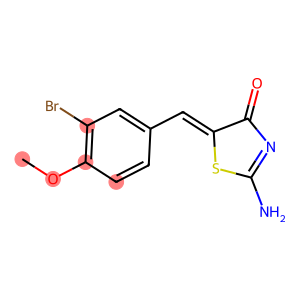

25 safe 2


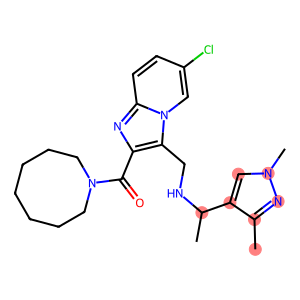

25 sus 1


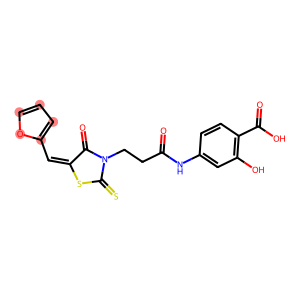

25 sus 2


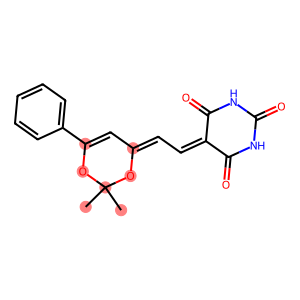

13 safe 1


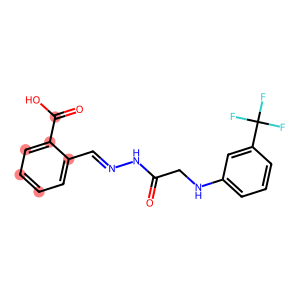

13 safe 2


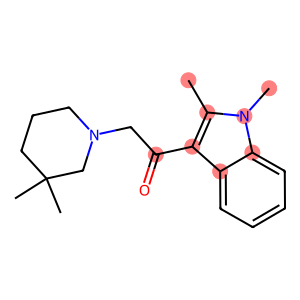

13 sus 1


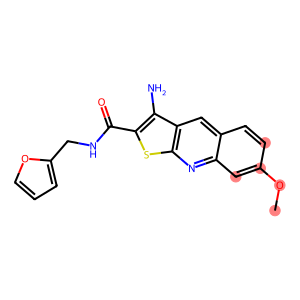

13 sus 2


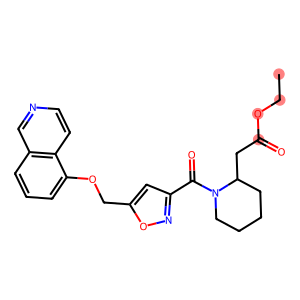

439 safe 1


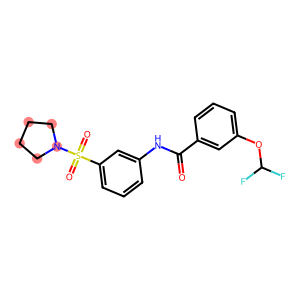

439 safe 2


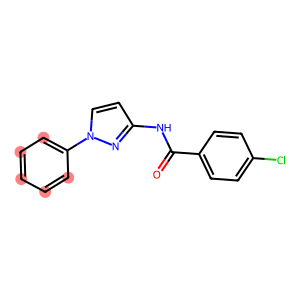

439 sus 1


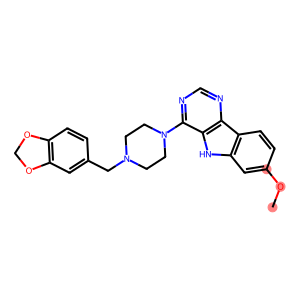

439 sus 2


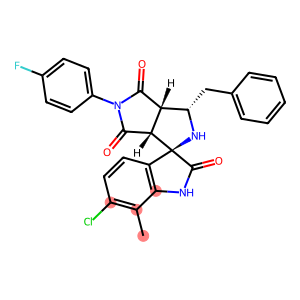

444 safe 1


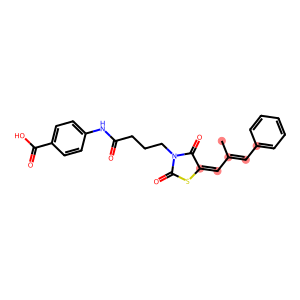

444 safe 2


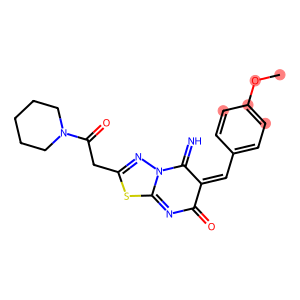

444 sus 1


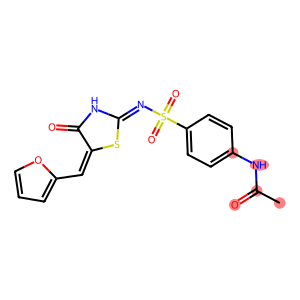

444 sus 2


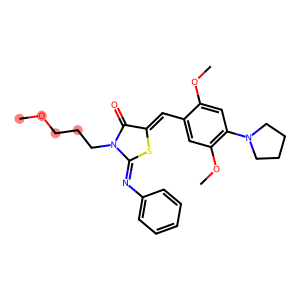

791 safe 1


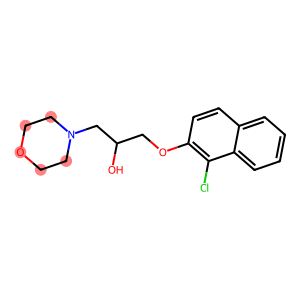

791 safe 2


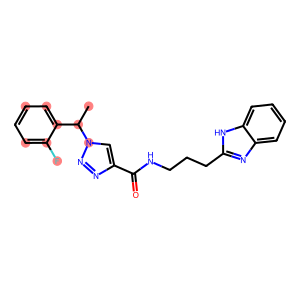

791 sus 1


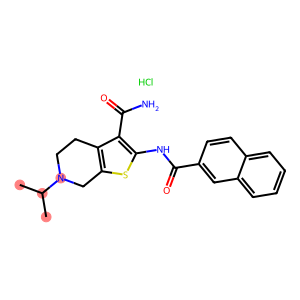

791 sus 2


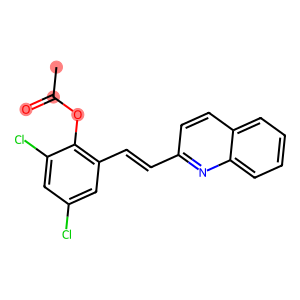

313 safe 1


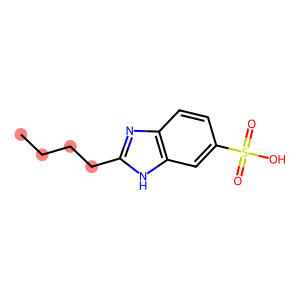

313 safe 2


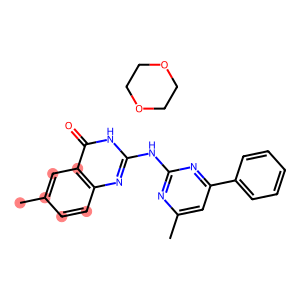

313 sus 1


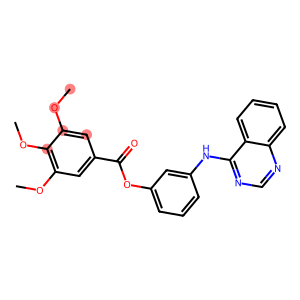

313 sus 2


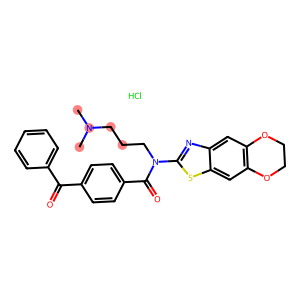

151 safe 1


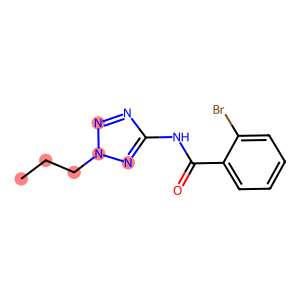

151 safe 2


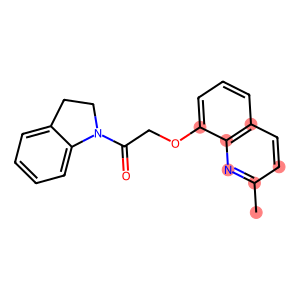

151 sus 1


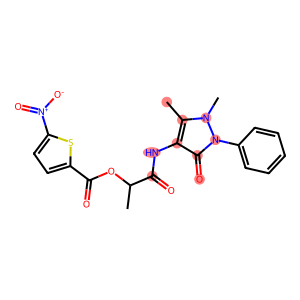

151 sus 2


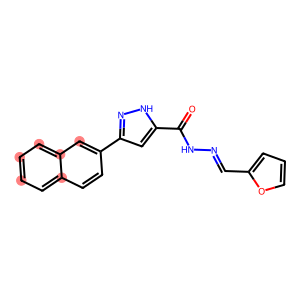

171 safe 1


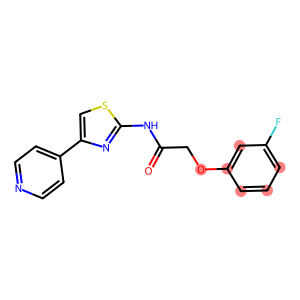

171 safe 2


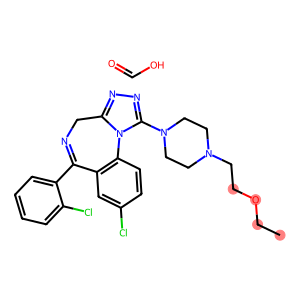

171 sus 1


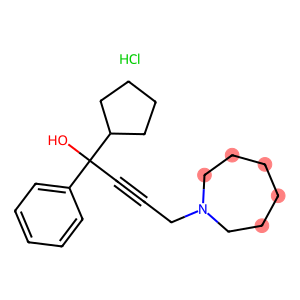

171 sus 2


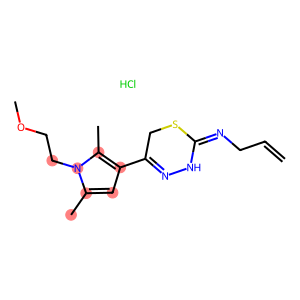

961 safe 1


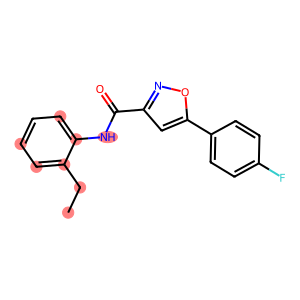

961 safe 2


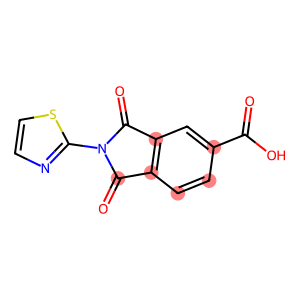

961 sus 1


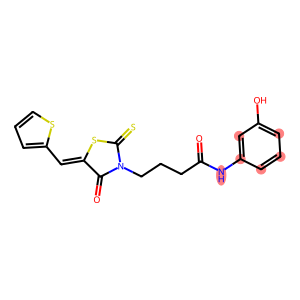

961 sus 2


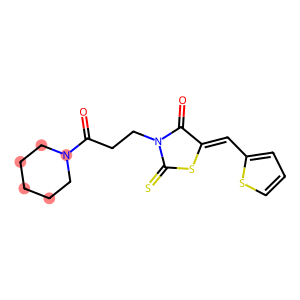

In [629]:
for bit_index in top_indices:
    for set_name in ["safe", "sus"]:
        for example_num in range(1, 3):
            print(bit_index, set_name, example_num)
            img = get_random_mol_with_bit(set_name, int(bit_index))
            display(img)